# NARPS: Parametric design- 1st level analysis

Parametric effect of gain:
1. Positive effect in ventromedial PFC - for the equal indifference group
2. Positive effect in ventromedial PFC - for the equal range group
3. Positive effect in ventral striatum - for the equal indifference group
4. Positive effect in ventral striatum - for the equal range group

Parametric effect of loss:
5. Negative effect in VMPFC - for the equal indifference group
6. Negative effect in VMPFC - for the equal range group
7. Positive effect in amygdala - for the equal indifference group
8. Positive effect in amygdala - for the equal range group

Equal range vs. equal indifference:
9. Greater positive response to losses in amygdala for equal range condition vs. equal
indifference condition.

Other info:
- N = 108 (equal indifference group (n = 54), equal range group (n = 54))

In [9]:
%matplotlib inline

In [10]:
import socket
import random
import os
import pandas as pd
import numpy as np
from glob import glob
import nibabel as nib
import nistats
from nilearn import plotting
import matplotlib.pyplot as plt
from nistats.reporting import plot_design_matrix
from nilearn.plotting import plot_stat_map, plot_anat, plot_img
from nistats.thresholding import map_threshold

In [11]:
myhost = socket.gethostname()
if myhost == 'lmn-pc':
    root = '/media/lmn/86A406A0A406933B5/narps'
print(root)

/media/lmn/86A406A0A406933B5/narps


In [12]:
# Make nistats folder 
# if not os.path.exists(root + '/derivatives/nistats'):
    # os.makedirs(root + '/derivatives/nistats')
# make first level folder
# if not os.path.exists(root + '/derivatives/nistats/1stlevel'):
    # os.makedirs(root + '/derivatives/nistats/1st_level')

In [13]:
preproc_path = root + '/derivatives/fmriflows/preproc_'

In [14]:
# Load subject identifiers
subject_ids = [s[-7:] for s in sorted(glob(preproc_path + 'func/sub-*'))]
ID = [36, 37, 38, 70, 72]
# subject_ids = subject_ids[:60]
subject_ids = ['sub-094','sub-095','sub-096','sub-098']
subject_ids

['sub-094', 'sub-095', 'sub-096', 'sub-098']

In [15]:
subject_func = [s[-7:] for s in sorted(glob(preproc_path + 'func/sub-*'))]
subject_stats = [s[-7:] for s in sorted(glob(root + '/derivatives/nistats/1st_level/sub-*'))]
subject_ids = [s for s in subject_func if s not in subject_stats]
subject_ids

['sub-016',
 'sub-017',
 'sub-018',
 'sub-019',
 'sub-020',
 'sub-021',
 'sub-022',
 'sub-024',
 'sub-025',
 'sub-026',
 'sub-027',
 'sub-029',
 'sub-030',
 'sub-114',
 'sub-115',
 'sub-116',
 'sub-117',
 'sub-118',
 'sub-119',
 'sub-120',
 'sub-121',
 'sub-123',
 'sub-124']

In [16]:
# Load functional data
func_data = [preproc_path + 'func/{0}/{0}_task-MGT_run-{1:02d}_tFilter_None.100.0_sFilter_LP_6.0mm.nii.gz'.format(s, r)
             for s in subject_ids for r in range(1, 5)]
len(func_data)

92

In [17]:
# Load anatomical data
anat_data = [preproc_path + 'anat/{0}/{0}_T1w_corrected.nii.gz'.format(s) for s in subject_ids]
len(anat_data)

23

In [18]:
# Load participants file
parti_file = root + '/event_tsvs/participants.tsv'
parti = pd.read_csv(parti_file, sep='\t')
subject_selecter = [p in subject_ids for p in parti['participant_id']]
parti = parti[subject_selecter]
len(parti)

# Different groups
grp01 = parti.loc[parti['group'] == 'equalIndifference']
grp02 = parti.loc[parti['group'] == 'equalRange']
grp01_ind = grp01.index.get_values()
grp02_ind = grp02.index.get_values()

In [19]:
# Load confounds files
conf_data = [preproc_path + 'func/{0}/{0}_task-MGT_run-{1:02d}_tFilter_None.100.0_confounds.tsv'.format(s, r)
             for s in subject_ids for r in range(1, 5)]
len(conf_data)

92

In [20]:
# nss files
nss_files = [preproc_path + 'func/{0}/{0}_task-MGT_run-{1:02d}_nss.txt'.format(s, r)
             for s in subject_ids for r in range(1, 5)]
ev_files = [root + '/event_tsvs/{0}_task-MGT_run-{1:02d}_events.tsv'.format(s, r)
            for s in subject_ids for r in range(1, 5)]
len(nss_files)

92

In [21]:
# load and modify the event files
tr =1
ind = np.arange(0, len(nss_files) + 1, 4)
ev_data = []
for s, sub in enumerate(subject_ids):
    # print('Subject:', sub)
    run_nss_files = nss_files[ind[s]:ind[s+1]]
    run_ev_files = ev_files[ind[s]:ind[s+1]]
    for run in range(4):
        nss_file = run_nss_files[run]
        nss_delay = tr * np.loadtxt(nss_file)
        ev_file = run_ev_files[run]
        df = pd.read_csv(ev_file, sep='\t')
        df['trial_type'] = np.where(df['participant_response'].str.contains("accept"), 'accept', 'reject')
        df['onset'] = df['onset'] - nss_delay
        df['modulation'] = np.abs(df['gain'] - df['loss'])
        ev_data.append(df)
len(ev_data)

92

In [22]:
# Define some parameters
TR = 1
runs_per_sub = 4
print('TR:', int(TR))
nr_sub = int(len(func_data) / runs_per_sub)
print('Nr of subjects:', nr_sub)
nr_files = len(func_data)
print('Nr of functional files:', int(nr_files))

data_shape = nib.load(func_data[2]).header.get_data_shape()
# when there is cut
n_scans = data_shape[3]
print('Nr of scans in each func file:', int(n_scans))
nr_cond = df['trial_type'].nunique()
print('Experimental conditions:', df['trial_type'].unique())
nr_groups = parti['group'].nunique()
print('Experimental Groups:', parti['group'].unique())
nr_trials = len(df)
print('Nr trials in one run:', nr_trials)
epoch_duration = 4 # in sec
frame_times = np.arange(n_scans) * TR


TR: 1
Nr of subjects: 23
Nr of functional files: 92
Nr of scans in each func file: 452
Experimental conditions: ['accept' 'reject']
Experimental Groups: ['equalRange' 'equalIndifference']
Nr trials in one run: 64


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


In [23]:
# what is the lowest and highest nr of volumes in the runs
x =[]
for i in range(len(func_data)):
    data_shape = nib.load(func_data[i]).header.get_data_shape()
    x.append(data_shape[3])
print(min(x), max(x))

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)


447 453


In [24]:
# Create a list of dataframes with motion confounds and framewise disp
motion_conf_all = []
for conf in conf_data:
    temp_df = pd.read_csv(conf, delimiter='\t')
    sub_motion_params = pd.DataFrame(temp_df, columns=['Translation01', 'Translation02', 'Translation03', 'Rotation01', 'Rotation02', 'Rotation03', 'FD', 'DVARS', 'TV'] )
    sub_motion_params['FD'][0] = 0 # Change the first elem to 0 from Nan
    motion_conf_all.append(sub_motion_params)
len(motion_conf_all)

92

In [25]:
# define some model parameters
drift_model = 'cosine'
period_cut = 100
hrf_models = ['spm', 'spm + derivative', 'spm + derivative + dispersion', 
              'glover', 'glover + derivative', 'glover + derivative + dispersion', 'fir']
hrf_model = hrf_models[0]
# define the model
from nistats.first_level_model import FirstLevelModel

fmri_glm = FirstLevelModel(TR, noise_model='ar1',
                           standardize=False, hrf_model=hrf_model,
                           drift_model=drift_model,
                           period_cut=period_cut)

/home/lmn/install/miniconda3/lib/python3.6/site-packages/duecredit/utils.py:32: PendingDeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \
/home/lmn/install/miniconda3/lib/python3.6/site-packages/traitsui/ui_traits.py:327: DeprecationWarning: use "HasTraits.trait_set" instead
  self.set( left = left, right = right, top = top, bottom = bottom )


sub-016
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-016
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely inter

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:35:28,827 nipype.interface INFO:
	 stdout 2019-03-10T07:35:28.827779:Using single precision for computations.
190310-07:35:28,829 nipype.interface INFO:
	 stdout 2019-03-10T07:35:28.829300:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-016/sub-016_zmap_Accept.nii.gz
190310-07:35:28,850 nipype.interface INFO:
	 stdout 2019-03-10T07:35:28.850684:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:35:30,490 nipype.interface INFO:
	 stdout 2019-03-10T07:35:30.490832:=============================================================================
190310-07:35:30,491 nipype.interface INFO:
	 stdout 2019-03-10T07:35:30.490832:The composite transform comprises the following transforms (in order): 
190310-07:35:30,492 nipype.interface INFO:
	 stdout 2019-03-10T07:35:30.490832:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-016/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:35:47,375 nipype.interface INFO:
	 stdout 2019-03-10T07:35:47.375754:Using single precision for computations.
190310-07:35:47,377 nipype.interface INFO:
	 stdout 2019-03-10T07:35:47.375754:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-016/sub-016_zmap_Reject.nii.gz
190310-07:35:47,389 nipype.interface INFO:
	 stdout 2019-03-10T07:35:47.389077:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:35:47,696 nipype.interface INFO:
	 stdout 2019-03-10T07:35:47.696080:=============================================================================
190310-07:35:47,697 nipype.interface INFO:
	 stdout 2019-03-10T07:35:47.696080:The composite transform comprises the following transforms (in order): 
190310-07:35:47,697 nipype.interface INFO:
	 stdout 2019-03-10T07:35:47.696080:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-016/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:36:06,393 nipype.interface INFO:
	 stdout 2019-03-10T07:36:06.393235:Using single precision for computations.
190310-07:36:06,394 nipype.interface INFO:
	 stdout 2019-03-10T07:36:06.393235:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-016/sub-016_zmap_AcceptVsReject.nii.gz
190310-07:36:06,407 nipype.interface INFO:
	 stdout 2019-03-10T07:36:06.407796:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:36:06,714 nipype.interface INFO:
	 stdout 2019-03-10T07:36:06.714659:=============================================================================
190310-07:36:06,715 nipype.interface INFO:
	 stdout 2019-03-10T07:36:06.714659:The composite transform comprises the following transforms (in order): 
190310-07:36:06,716 nipype.interface INFO:
	 stdout 2019-03-10T07:36:06.714659:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090
sub-017
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-017
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:37:15,686 nipype.interface INFO:
	 stdout 2019-03-10T07:37:15.686603:Using single precision for computations.
190310-07:37:15,687 nipype.interface INFO:
	 stdout 2019-03-10T07:37:15.686603:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-017/sub-017_zmap_Accept.nii.gz
190310-07:37:15,701 nipype.interface INFO:
	 stdout 2019-03-10T07:37:15.701575:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:37:17,180 nipype.interface INFO:
	 stdout 2019-03-10T07:37:17.180325:=============================================================================
190310-07:37:17,181 nipype.interface INFO:
	 stdout 2019-03-10T07:37:17.180325:The composite transform comprises the following transforms (in order): 
190310-07:37:17,181 nipype.interface INFO:
	 stdout 2019-03-10T07:37:17.180325:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-017/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:37:40,106 nipype.interface INFO:
	 stdout 2019-03-10T07:37:40.106223:Using single precision for computations.
190310-07:37:40,107 nipype.interface INFO:
	 stdout 2019-03-10T07:37:40.106223:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-017/sub-017_zmap_Reject.nii.gz
190310-07:37:40,121 nipype.interface INFO:
	 stdout 2019-03-10T07:37:40.121055:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:37:40,426 nipype.interface INFO:
	 stdout 2019-03-10T07:37:40.426255:=============================================================================
190310-07:37:40,427 nipype.interface INFO:
	 stdout 2019-03-10T07:37:40.426255:The composite transform comprises the following transforms (in order): 
190310-07:37:40,427 nipype.interface INFO:
	 stdout 2019-03-10T07:37:40.426255:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-017/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:38:04,886 nipype.interface INFO:
	 stdout 2019-03-10T07:38:04.886308:Using single precision for computations.
190310-07:38:04,887 nipype.interface INFO:
	 stdout 2019-03-10T07:38:04.886308:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-017/sub-017_zmap_AcceptVsReject.nii.gz
190310-07:38:04,899 nipype.interface INFO:
	 stdout 2019-03-10T07:38:04.899515:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:38:05,199 nipype.interface INFO:
	 stdout 2019-03-10T07:38:05.199175:=============================================================================
190310-07:38:05,200 nipype.interface INFO:
	 stdout 2019-03-10T07:38:05.199175:The composite transform comprises the following transforms (in order): 
190310-07:38:05,200 nipype.interface INFO:
	 stdout 2019-03-10T07:38:05.199175:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090
sub-018
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-018
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:39:36,71 nipype.interface INFO:
	 stdout 2019-03-10T07:39:36.071865:Using single precision for computations.
190310-07:39:36,73 nipype.interface INFO:
	 stdout 2019-03-10T07:39:36.071865:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-018/sub-018_zmap_Accept.nii.gz
190310-07:39:36,86 nipype.interface INFO:
	 stdout 2019-03-10T07:39:36.086061:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:39:37,627 nipype.interface INFO:
	 stdout 2019-03-10T07:39:37.627301:=============================================================================
190310-07:39:37,628 nipype.interface INFO:
	 stdout 2019-03-10T07:39:37.627301:The composite transform comprises the following transforms (in order): 
190310-07:39:37,629 nipype.interface INFO:
	 stdout 2019-03-10T07:39:37.627301:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-018/sub-018_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:40:06,667 nipype.interface INFO:
	 stdout 2019-03-10T07:40:06.666910:Using single precision for computations.
190310-07:40:06,668 nipype.interface INFO:
	 stdout 2019-03-10T07:40:06.666910:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-018/sub-018_zmap_Reject.nii.gz
190310-07:40:06,681 nipype.interface INFO:
	 stdout 2019-03-10T07:40:06.681316:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:40:06,980 nipype.interface INFO:
	 stdout 2019-03-10T07:40:06.980424:=============================================================================
190310-07:40:06,981 nipype.interface INFO:
	 stdout 2019-03-10T07:40:06.980424:The composite transform comprises the following transforms (in order): 
190310-07:40:06,982 nipype.interface INFO:
	 stdout 2019-03-10T07:40:06.980424:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-018/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:40:37,409 nipype.interface INFO:
	 stdout 2019-03-10T07:40:37.409728:Using single precision for computations.
190310-07:40:37,411 nipype.interface INFO:
	 stdout 2019-03-10T07:40:37.409728:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-018/sub-018_zmap_AcceptVsReject.nii.gz
190310-07:40:37,422 nipype.interface INFO:
	 stdout 2019-03-10T07:40:37.422876:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:40:37,721 nipype.interface INFO:
	 stdout 2019-03-10T07:40:37.720952:=============================================================================
190310-07:40:37,722 nipype.interface INFO:
	 stdout 2019-03-10T07:40:37.720952:The composite transform comprises the following transforms (in order): 
190310-07:40:37,722 nipype.interface INFO:
	 stdout 2019-03-10T07:40:37.720952:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090
sub-019
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-019
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:42:19,311 nipype.interface INFO:
	 stdout 2019-03-10T07:42:19.311029:Using single precision for computations.
190310-07:42:19,312 nipype.interface INFO:
	 stdout 2019-03-10T07:42:19.311029:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-019/sub-019_zmap_Accept.nii.gz
190310-07:42:19,325 nipype.interface INFO:
	 stdout 2019-03-10T07:42:19.325667:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:42:20,821 nipype.interface INFO:
	 stdout 2019-03-10T07:42:20.821152:=============================================================================
190310-07:42:20,822 nipype.interface INFO:
	 stdout 2019-03-10T07:42:20.821152:The composite transform comprises the following transforms (in order): 
190310-07:42:20,822 nipype.interface INFO:
	 stdout 2019-03-10T07:42:20.821152:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-019/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:42:55,565 nipype.interface INFO:
	 stdout 2019-03-10T07:42:55.565088:Using single precision for computations.
190310-07:42:55,566 nipype.interface INFO:
	 stdout 2019-03-10T07:42:55.565088:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-019/sub-019_zmap_Reject.nii.gz
190310-07:42:55,580 nipype.interface INFO:
	 stdout 2019-03-10T07:42:55.580664:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:42:55,877 nipype.interface INFO:
	 stdout 2019-03-10T07:42:55.877427:=============================================================================
190310-07:42:55,878 nipype.interface INFO:
	 stdout 2019-03-10T07:42:55.877427:The composite transform comprises the following transforms (in order): 
190310-07:42:55,878 nipype.interface INFO:
	 stdout 2019-03-10T07:42:55.877427:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-019/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:43:32,479 nipype.interface INFO:
	 stdout 2019-03-10T07:43:32.479880:Using single precision for computations.
190310-07:43:32,481 nipype.interface INFO:
	 stdout 2019-03-10T07:43:32.479880:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-019/sub-019_zmap_AcceptVsReject.nii.gz
190310-07:43:32,494 nipype.interface INFO:
	 stdout 2019-03-10T07:43:32.494482:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:43:32,789 nipype.interface INFO:
	 stdout 2019-03-10T07:43:32.789630:=============================================================================
190310-07:43:32,790 nipype.interface INFO:
	 stdout 2019-03-10T07:43:32.789630:The composite transform comprises the following transforms (in order): 
190310-07:43:32,791 nipype.interface INFO:
	 stdout 2019-03-10T07:43:32.789630:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-01

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090
sub-020
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-020
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:45:15,169 nipype.interface INFO:
	 stdout 2019-03-10T07:45:15.169482:Using single precision for computations.
190310-07:45:15,171 nipype.interface INFO:
	 stdout 2019-03-10T07:45:15.169482:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-020/sub-020_zmap_Accept.nii.gz
190310-07:45:15,184 nipype.interface INFO:
	 stdout 2019-03-10T07:45:15.184030:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:45:16,708 nipype.interface INFO:
	 stdout 2019-03-10T07:45:16.707982:=============================================================================
190310-07:45:16,709 nipype.interface INFO:
	 stdout 2019-03-10T07:45:16.707982:The composite transform comprises the following transforms (in order): 
190310-07:45:16,709 nipype.interface INFO:
	 stdout 2019-03-10T07:45:16.707982:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-020/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:45:57,219 nipype.interface INFO:
	 stdout 2019-03-10T07:45:57.219200:Using single precision for computations.
190310-07:45:57,220 nipype.interface INFO:
	 stdout 2019-03-10T07:45:57.219200:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-020/sub-020_zmap_Reject.nii.gz
190310-07:45:57,233 nipype.interface INFO:
	 stdout 2019-03-10T07:45:57.233818:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:45:57,534 nipype.interface INFO:
	 stdout 2019-03-10T07:45:57.534112:=============================================================================
190310-07:45:57,535 nipype.interface INFO:
	 stdout 2019-03-10T07:45:57.534112:The composite transform comprises the following transforms (in order): 
190310-07:45:57,535 nipype.interface INFO:
	 stdout 2019-03-10T07:45:57.534112:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-020/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:46:40,55 nipype.interface INFO:
	 stdout 2019-03-10T07:46:40.055056:Using single precision for computations.
190310-07:46:40,56 nipype.interface INFO:
	 stdout 2019-03-10T07:46:40.055056:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-020/sub-020_zmap_AcceptVsReject.nii.gz
190310-07:46:40,70 nipype.interface INFO:
	 stdout 2019-03-10T07:46:40.070086:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:46:40,374 nipype.interface INFO:
	 stdout 2019-03-10T07:46:40.374151:=============================================================================
190310-07:46:40,375 nipype.interface INFO:
	 stdout 2019-03-10T07:46:40.374151:The composite transform comprises the following transforms (in order): 
190310-07:46:40,376 nipype.interface INFO:
	 stdout 2019-03-10T07:46:40.374151:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-020/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090
sub-021
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-021
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:48:27,989 nipype.interface INFO:
	 stdout 2019-03-10T07:48:27.989896:Using single precision for computations.
190310-07:48:27,991 nipype.interface INFO:
	 stdout 2019-03-10T07:48:27.989896:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-021/sub-021_zmap_Accept.nii.gz
190310-07:48:28,4 nipype.interface INFO:
	 stdout 2019-03-10T07:48:28.004097:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:48:29,505 nipype.interface INFO:
	 stdout 2019-03-10T07:48:29.505856:=============================================================================
190310-07:48:29,506 nipype.interface INFO:
	 stdout 2019-03-10T07:48:29.505856:The composite transform comprises the following transforms (in order): 
190310-07:48:29,507 nipype.interface INFO:
	 stdout 2019-03-10T07:48:29.505856:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-021/sub-021_

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:49:16,224 nipype.interface INFO:
	 stdout 2019-03-10T07:49:16.223967:Using single precision for computations.
190310-07:49:16,225 nipype.interface INFO:
	 stdout 2019-03-10T07:49:16.223967:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-021/sub-021_zmap_Reject.nii.gz
190310-07:49:16,238 nipype.interface INFO:
	 stdout 2019-03-10T07:49:16.238266:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:49:16,558 nipype.interface INFO:
	 stdout 2019-03-10T07:49:16.558241:=============================================================================
190310-07:49:16,559 nipype.interface INFO:
	 stdout 2019-03-10T07:49:16.558241:The composite transform comprises the following transforms (in order): 
190310-07:49:16,560 nipype.interface INFO:
	 stdout 2019-03-10T07:49:16.558241:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-021/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


190310-07:50:04,900 nipype.interface INFO:
	 stdout 2019-03-10T07:50:04.900305:Using single precision for computations.
190310-07:50:04,901 nipype.interface INFO:
	 stdout 2019-03-10T07:50:04.900305:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-021/sub-021_zmap_AcceptVsReject.nii.gz
190310-07:50:04,913 nipype.interface INFO:
	 stdout 2019-03-10T07:50:04.913841:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:50:05,226 nipype.interface INFO:
	 stdout 2019-03-10T07:50:05.226078:=============================================================================
190310-07:50:05,226 nipype.interface INFO:
	 stdout 2019-03-10T07:50:05.226078:The composite transform comprises the following transforms (in order): 
190310-07:50:05,227 nipype.interface INFO:
	 stdout 2019-03-10T07:50:05.226078:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090
sub-022
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-022
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-07:52:58,720 nipype.interface INFO:
	 stdout 2019-03-10T07:52:58.720236:Using single precision for computations.
190310-07:52:58,721 nipype.interface INFO:
	 stdout 2019-03-10T07:52:58.720236:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-022/sub-022_zmap_Accept.nii.gz
190310-07:52:58,735 nipype.interface INFO:
	 stdout 2019-03-10T07:52:58.735788:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:53:00,214 nipype.interface INFO:
	 stdout 2019-03-10T07:53:00.214357:=============================================================================
190310-07:53:00,215 nipype.interface INFO:
	 stdout 2019-03-10T07:53:00.214357:The composite transform comprises the following transforms (in order): 
190310-07:53:00,216 nipype.interface INFO:
	 stdout 2019-03-10T07:53:00.214357:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-022/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-07:53:52,948 nipype.interface INFO:
	 stdout 2019-03-10T07:53:52.947941:Using single precision for computations.
190310-07:53:52,949 nipype.interface INFO:
	 stdout 2019-03-10T07:53:52.947941:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-022/sub-022_zmap_Reject.nii.gz
190310-07:53:52,964 nipype.interface INFO:
	 stdout 2019-03-10T07:53:52.964005:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:53:53,281 nipype.interface INFO:
	 stdout 2019-03-10T07:53:53.281397:=============================================================================
190310-07:53:53,282 nipype.interface INFO:
	 stdout 2019-03-10T07:53:53.281397:The composite transform comprises the following transforms (in order): 
190310-07:53:53,283 nipype.interface INFO:
	 stdout 2019-03-10T07:53:53.281397:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-022/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-07:54:47,691 nipype.interface INFO:
	 stdout 2019-03-10T07:54:47.691756:Using single precision for computations.
190310-07:54:47,693 nipype.interface INFO:
	 stdout 2019-03-10T07:54:47.691756:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-022/sub-022_zmap_AcceptVsReject.nii.gz
190310-07:54:47,707 nipype.interface INFO:
	 stdout 2019-03-10T07:54:47.707528:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:54:48,18 nipype.interface INFO:
	 stdout 2019-03-10T07:54:48.018252:=============================================================================
190310-07:54:48,19 nipype.interface INFO:
	 stdout 2019-03-10T07:54:48.018252:The composite transform comprises the following transforms (in order): 
190310-07:54:48,19 nipype.interface INFO:
	 stdout 2019-03-10T07:54:48.018252:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-022/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-024
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-024
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-07:57:07,897 nipype.interface INFO:
	 stdout 2019-03-10T07:57:07.897221:Using single precision for computations.
190310-07:57:07,898 nipype.interface INFO:
	 stdout 2019-03-10T07:57:07.897221:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-024/sub-024_zmap_Accept.nii.gz
190310-07:57:07,914 nipype.interface INFO:
	 stdout 2019-03-10T07:57:07.914524:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:57:09,414 nipype.interface INFO:
	 stdout 2019-03-10T07:57:09.414617:=============================================================================
190310-07:57:09,415 nipype.interface INFO:
	 stdout 2019-03-10T07:57:09.414617:The composite transform comprises the following transforms (in order): 
190310-07:57:09,416 nipype.interface INFO:
	 stdout 2019-03-10T07:57:09.414617:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-024/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-07:58:08,29 nipype.interface INFO:
	 stdout 2019-03-10T07:58:08.029095:Using single precision for computations.
190310-07:58:08,30 nipype.interface INFO:
	 stdout 2019-03-10T07:58:08.029095:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-024/sub-024_zmap_Reject.nii.gz
190310-07:58:08,44 nipype.interface INFO:
	 stdout 2019-03-10T07:58:08.044624:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:58:08,353 nipype.interface INFO:
	 stdout 2019-03-10T07:58:08.353684:=============================================================================
190310-07:58:08,354 nipype.interface INFO:
	 stdout 2019-03-10T07:58:08.353684:The composite transform comprises the following transforms (in order): 
190310-07:58:08,355 nipype.interface INFO:
	 stdout 2019-03-10T07:58:08.353684:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-024/sub-024_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-07:59:07,951 nipype.interface INFO:
	 stdout 2019-03-10T07:59:07.951082:Using single precision for computations.
190310-07:59:07,952 nipype.interface INFO:
	 stdout 2019-03-10T07:59:07.951082:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-024/sub-024_zmap_AcceptVsReject.nii.gz
190310-07:59:07,966 nipype.interface INFO:
	 stdout 2019-03-10T07:59:07.966139:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-07:59:08,270 nipype.interface INFO:
	 stdout 2019-03-10T07:59:08.270830:=============================================================================
190310-07:59:08,271 nipype.interface INFO:
	 stdout 2019-03-10T07:59:08.270830:The composite transform comprises the following transforms (in order): 
190310-07:59:08,272 nipype.interface INFO:
	 stdout 2019-03-10T07:59:08.270830:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-025
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-025
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:01:39,71 nipype.interface INFO:
	 stdout 2019-03-10T08:01:39.071448:Using single precision for computations.
190310-08:01:39,72 nipype.interface INFO:
	 stdout 2019-03-10T08:01:39.071448:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-025/sub-025_zmap_Accept.nii.gz
190310-08:01:39,90 nipype.interface INFO:
	 stdout 2019-03-10T08:01:39.089984:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:01:40,555 nipype.interface INFO:
	 stdout 2019-03-10T08:01:40.554976:=============================================================================
190310-08:01:40,556 nipype.interface INFO:
	 stdout 2019-03-10T08:01:40.554976:The composite transform comprises the following transforms (in order): 
190310-08:01:40,556 nipype.interface INFO:
	 stdout 2019-03-10T08:01:40.554976:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-025/sub-025_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:02:45,577 nipype.interface INFO:
	 stdout 2019-03-10T08:02:45.577681:Using single precision for computations.
190310-08:02:45,579 nipype.interface INFO:
	 stdout 2019-03-10T08:02:45.577681:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-025/sub-025_zmap_Reject.nii.gz
190310-08:02:45,596 nipype.interface INFO:
	 stdout 2019-03-10T08:02:45.596537:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:02:45,911 nipype.interface INFO:
	 stdout 2019-03-10T08:02:45.911787:=============================================================================
190310-08:02:45,912 nipype.interface INFO:
	 stdout 2019-03-10T08:02:45.911787:The composite transform comprises the following transforms (in order): 
190310-08:02:45,913 nipype.interface INFO:
	 stdout 2019-03-10T08:02:45.911787:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-025/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:03:51,986 nipype.interface INFO:
	 stdout 2019-03-10T08:03:51.985918:Using single precision for computations.
190310-08:03:51,987 nipype.interface INFO:
	 stdout 2019-03-10T08:03:51.985918:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-025/sub-025_zmap_AcceptVsReject.nii.gz
190310-08:03:52,5 nipype.interface INFO:
	 stdout 2019-03-10T08:03:52.005462:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:03:52,310 nipype.interface INFO:
	 stdout 2019-03-10T08:03:52.310427:=============================================================================
190310-08:03:52,311 nipype.interface INFO:
	 stdout 2019-03-10T08:03:52.310427:The composite transform comprises the following transforms (in order): 
190310-08:03:52,312 nipype.interface INFO:
	 stdout 2019-03-10T08:03:52.310427:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-025/

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-026
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-026
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:06:18,807 nipype.interface INFO:
	 stdout 2019-03-10T08:06:18.807647:Using single precision for computations.
190310-08:06:18,809 nipype.interface INFO:
	 stdout 2019-03-10T08:06:18.807647:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-026/sub-026_zmap_Accept.nii.gz
190310-08:06:18,824 nipype.interface INFO:
	 stdout 2019-03-10T08:06:18.824259:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:06:20,294 nipype.interface INFO:
	 stdout 2019-03-10T08:06:20.293942:=============================================================================
190310-08:06:20,294 nipype.interface INFO:
	 stdout 2019-03-10T08:06:20.293942:The composite transform comprises the following transforms (in order): 
190310-08:06:20,295 nipype.interface INFO:
	 stdout 2019-03-10T08:06:20.293942:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-026/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:07:30,184 nipype.interface INFO:
	 stdout 2019-03-10T08:07:30.184739:Using single precision for computations.
190310-08:07:30,186 nipype.interface INFO:
	 stdout 2019-03-10T08:07:30.184739:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-026/sub-026_zmap_Reject.nii.gz
190310-08:07:30,200 nipype.interface INFO:
	 stdout 2019-03-10T08:07:30.200450:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:07:30,510 nipype.interface INFO:
	 stdout 2019-03-10T08:07:30.510430:=============================================================================
190310-08:07:30,511 nipype.interface INFO:
	 stdout 2019-03-10T08:07:30.510430:The composite transform comprises the following transforms (in order): 
190310-08:07:30,511 nipype.interface INFO:
	 stdout 2019-03-10T08:07:30.510430:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-026/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:08:42,820 nipype.interface INFO:
	 stdout 2019-03-10T08:08:42.820318:Using single precision for computations.
190310-08:08:42,821 nipype.interface INFO:
	 stdout 2019-03-10T08:08:42.820318:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-026/sub-026_zmap_AcceptVsReject.nii.gz
190310-08:08:42,837 nipype.interface INFO:
	 stdout 2019-03-10T08:08:42.837045:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:08:43,143 nipype.interface INFO:
	 stdout 2019-03-10T08:08:43.143030:=============================================================================
190310-08:08:43,144 nipype.interface INFO:
	 stdout 2019-03-10T08:08:43.143030:The composite transform comprises the following transforms (in order): 
190310-08:08:43,144 nipype.interface INFO:
	 stdout 2019-03-10T08:08:43.143030:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-027
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-027
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:11:05,983 nipype.interface INFO:
	 stdout 2019-03-10T08:11:05.983079:Using single precision for computations.
190310-08:11:05,984 nipype.interface INFO:
	 stdout 2019-03-10T08:11:05.983079:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-027/sub-027_zmap_Accept.nii.gz
190310-08:11:05,997 nipype.interface INFO:
	 stdout 2019-03-10T08:11:05.997258:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:11:07,478 nipype.interface INFO:
	 stdout 2019-03-10T08:11:07.478168:=============================================================================
190310-08:11:07,479 nipype.interface INFO:
	 stdout 2019-03-10T08:11:07.478168:The composite transform comprises the following transforms (in order): 
190310-08:11:07,480 nipype.interface INFO:
	 stdout 2019-03-10T08:11:07.478168:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-027/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:12:23,440 nipype.interface INFO:
	 stdout 2019-03-10T08:12:23.440585:Using single precision for computations.
190310-08:12:23,442 nipype.interface INFO:
	 stdout 2019-03-10T08:12:23.440585:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-027/sub-027_zmap_Reject.nii.gz
190310-08:12:23,455 nipype.interface INFO:
	 stdout 2019-03-10T08:12:23.455221:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:12:23,768 nipype.interface INFO:
	 stdout 2019-03-10T08:12:23.768024:=============================================================================
190310-08:12:23,768 nipype.interface INFO:
	 stdout 2019-03-10T08:12:23.768024:The composite transform comprises the following transforms (in order): 
190310-08:12:23,769 nipype.interface INFO:
	 stdout 2019-03-10T08:12:23.768024:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-027/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:13:42,108 nipype.interface INFO:
	 stdout 2019-03-10T08:13:42.108377:Using single precision for computations.
190310-08:13:42,109 nipype.interface INFO:
	 stdout 2019-03-10T08:13:42.108377:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-027/sub-027_zmap_AcceptVsReject.nii.gz
190310-08:13:42,123 nipype.interface INFO:
	 stdout 2019-03-10T08:13:42.123339:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:13:42,430 nipype.interface INFO:
	 stdout 2019-03-10T08:13:42.429953:=============================================================================
190310-08:13:42,430 nipype.interface INFO:
	 stdout 2019-03-10T08:13:42.429953:The composite transform comprises the following transforms (in order): 
190310-08:13:42,431 nipype.interface INFO:
	 stdout 2019-03-10T08:13:42.429953:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-029
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-029
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:17:15,434 nipype.interface INFO:
	 stdout 2019-03-10T08:17:15.433966:Using single precision for computations.
190310-08:17:15,435 nipype.interface INFO:
	 stdout 2019-03-10T08:17:15.433966:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-029/sub-029_zmap_Accept.nii.gz
190310-08:17:15,451 nipype.interface INFO:
	 stdout 2019-03-10T08:17:15.451269:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:17:16,956 nipype.interface INFO:
	 stdout 2019-03-10T08:17:16.956357:=============================================================================
190310-08:17:16,957 nipype.interface INFO:
	 stdout 2019-03-10T08:17:16.956357:The composite transform comprises the following transforms (in order): 
190310-08:17:16,958 nipype.interface INFO:
	 stdout 2019-03-10T08:17:16.956357:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-029/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:18:39,253 nipype.interface INFO:
	 stdout 2019-03-10T08:18:39.253350:Using single precision for computations.
190310-08:18:39,254 nipype.interface INFO:
	 stdout 2019-03-10T08:18:39.253350:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-029/sub-029_zmap_Reject.nii.gz
190310-08:18:39,268 nipype.interface INFO:
	 stdout 2019-03-10T08:18:39.268542:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:18:39,576 nipype.interface INFO:
	 stdout 2019-03-10T08:18:39.575936:=============================================================================
190310-08:18:39,576 nipype.interface INFO:
	 stdout 2019-03-10T08:18:39.575936:The composite transform comprises the following transforms (in order): 
190310-08:18:39,577 nipype.interface INFO:
	 stdout 2019-03-10T08:18:39.575936:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-029/sub-02

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:20:03,724 nipype.interface INFO:
	 stdout 2019-03-10T08:20:03.724220:Using single precision for computations.
190310-08:20:03,725 nipype.interface INFO:
	 stdout 2019-03-10T08:20:03.724220:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-029/sub-029_zmap_AcceptVsReject.nii.gz
190310-08:20:03,739 nipype.interface INFO:
	 stdout 2019-03-10T08:20:03.739745:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:20:04,45 nipype.interface INFO:
	 stdout 2019-03-10T08:20:04.045272:=============================================================================
190310-08:20:04,46 nipype.interface INFO:
	 stdout 2019-03-10T08:20:04.045272:The composite transform comprises the following transforms (in order): 
190310-08:20:04,47 nipype.interface INFO:
	 stdout 2019-03-10T08:20:04.045272:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-029/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-030
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-030
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:22:44,331 nipype.interface INFO:
	 stdout 2019-03-10T08:22:44.330856:Using single precision for computations.
190310-08:22:44,332 nipype.interface INFO:
	 stdout 2019-03-10T08:22:44.330856:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-030/sub-030_zmap_Accept.nii.gz
190310-08:22:44,348 nipype.interface INFO:
	 stdout 2019-03-10T08:22:44.348007:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:22:45,832 nipype.interface INFO:
	 stdout 2019-03-10T08:22:45.832778:=============================================================================
190310-08:22:45,834 nipype.interface INFO:
	 stdout 2019-03-10T08:22:45.832778:The composite transform comprises the following transforms (in order): 
190310-08:22:45,834 nipype.interface INFO:
	 stdout 2019-03-10T08:22:45.832778:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-030/sub-03

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:24:14,19 nipype.interface INFO:
	 stdout 2019-03-10T08:24:14.019477:Using single precision for computations.
190310-08:24:14,21 nipype.interface INFO:
	 stdout 2019-03-10T08:24:14.019477:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-030/sub-030_zmap_Reject.nii.gz
190310-08:24:14,36 nipype.interface INFO:
	 stdout 2019-03-10T08:24:14.036744:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:24:14,346 nipype.interface INFO:
	 stdout 2019-03-10T08:24:14.346877:=============================================================================
190310-08:24:14,347 nipype.interface INFO:
	 stdout 2019-03-10T08:24:14.346877:The composite transform comprises the following transforms (in order): 
190310-08:24:14,348 nipype.interface INFO:
	 stdout 2019-03-10T08:24:14.346877:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-030/sub-030_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:25:44,702 nipype.interface INFO:
	 stdout 2019-03-10T08:25:44.701995:Using single precision for computations.
190310-08:25:44,703 nipype.interface INFO:
	 stdout 2019-03-10T08:25:44.701995:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-030/sub-030_zmap_AcceptVsReject.nii.gz
190310-08:25:44,718 nipype.interface INFO:
	 stdout 2019-03-10T08:25:44.718281:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:25:45,26 nipype.interface INFO:
	 stdout 2019-03-10T08:25:45.026736:=============================================================================
190310-08:25:45,28 nipype.interface INFO:
	 stdout 2019-03-10T08:25:45.026736:The composite transform comprises the following transforms (in order): 
190310-08:25:45,28 nipype.interface INFO:
	 stdout 2019-03-10T08:25:45.026736:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-030/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-114
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-114
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:28:21,957 nipype.interface INFO:
	 stdout 2019-03-10T08:28:21.957754:Using single precision for computations.
190310-08:28:21,959 nipype.interface INFO:
	 stdout 2019-03-10T08:28:21.957754:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-114/sub-114_zmap_Accept.nii.gz
190310-08:28:21,972 nipype.interface INFO:
	 stdout 2019-03-10T08:28:21.972345:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:28:23,288 nipype.interface INFO:
	 stdout 2019-03-10T08:28:23.288594:=============================================================================
190310-08:28:23,289 nipype.interface INFO:
	 stdout 2019-03-10T08:28:23.288594:The composite transform comprises the following transforms (in order): 
190310-08:28:23,290 nipype.interface INFO:
	 stdout 2019-03-10T08:28:23.288594:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-114/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:29:57,520 nipype.interface INFO:
	 stdout 2019-03-10T08:29:57.520303:Using single precision for computations.
190310-08:29:57,521 nipype.interface INFO:
	 stdout 2019-03-10T08:29:57.520303:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-114/sub-114_zmap_Reject.nii.gz
190310-08:29:57,534 nipype.interface INFO:
	 stdout 2019-03-10T08:29:57.534529:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:29:57,845 nipype.interface INFO:
	 stdout 2019-03-10T08:29:57.845555:=============================================================================
190310-08:29:57,846 nipype.interface INFO:
	 stdout 2019-03-10T08:29:57.845555:The composite transform comprises the following transforms (in order): 
190310-08:29:57,847 nipype.interface INFO:
	 stdout 2019-03-10T08:29:57.845555:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-114/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:31:34,68 nipype.interface INFO:
	 stdout 2019-03-10T08:31:34.068541:Using single precision for computations.
190310-08:31:34,70 nipype.interface INFO:
	 stdout 2019-03-10T08:31:34.068541:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-114/sub-114_zmap_AcceptVsReject.nii.gz
190310-08:31:34,83 nipype.interface INFO:
	 stdout 2019-03-10T08:31:34.083695:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:31:34,390 nipype.interface INFO:
	 stdout 2019-03-10T08:31:34.390288:=============================================================================
190310-08:31:34,391 nipype.interface INFO:
	 stdout 2019-03-10T08:31:34.390288:The composite transform comprises the following transforms (in order): 
190310-08:31:34,392 nipype.interface INFO:
	 stdout 2019-03-10T08:31:34.390288:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-114/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-115
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-115
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:34:27,50 nipype.interface INFO:
	 stdout 2019-03-10T08:34:27.049992:Using single precision for computations.
190310-08:34:27,51 nipype.interface INFO:
	 stdout 2019-03-10T08:34:27.049992:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-115/sub-115_zmap_Accept.nii.gz
190310-08:34:27,66 nipype.interface INFO:
	 stdout 2019-03-10T08:34:27.066004:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:34:28,406 nipype.interface INFO:
	 stdout 2019-03-10T08:34:28.406051:=============================================================================
190310-08:34:28,407 nipype.interface INFO:
	 stdout 2019-03-10T08:34:28.406051:The composite transform comprises the following transforms (in order): 
190310-08:34:28,407 nipype.interface INFO:
	 stdout 2019-03-10T08:34:28.406051:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-115/sub-115_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:36:08,797 nipype.interface INFO:
	 stdout 2019-03-10T08:36:08.796995:Using single precision for computations.
190310-08:36:08,798 nipype.interface INFO:
	 stdout 2019-03-10T08:36:08.796995:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-115/sub-115_zmap_Reject.nii.gz
190310-08:36:08,814 nipype.interface INFO:
	 stdout 2019-03-10T08:36:08.814400:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:36:09,123 nipype.interface INFO:
	 stdout 2019-03-10T08:36:09.122950:=============================================================================
190310-08:36:09,123 nipype.interface INFO:
	 stdout 2019-03-10T08:36:09.122950:The composite transform comprises the following transforms (in order): 
190310-08:36:09,124 nipype.interface INFO:
	 stdout 2019-03-10T08:36:09.122950:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-115/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:37:51,210 nipype.interface INFO:
	 stdout 2019-03-10T08:37:51.210712:Using single precision for computations.
190310-08:37:51,212 nipype.interface INFO:
	 stdout 2019-03-10T08:37:51.210712:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-115/sub-115_zmap_AcceptVsReject.nii.gz
190310-08:37:51,227 nipype.interface INFO:
	 stdout 2019-03-10T08:37:51.227486:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:37:51,531 nipype.interface INFO:
	 stdout 2019-03-10T08:37:51.531715:=============================================================================
190310-08:37:51,532 nipype.interface INFO:
	 stdout 2019-03-10T08:37:51.531715:The composite transform comprises the following transforms (in order): 
190310-08:37:51,533 nipype.interface INFO:
	 stdout 2019-03-10T08:37:51.531715:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-116
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-116
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:40:46,69 nipype.interface INFO:
	 stdout 2019-03-10T08:40:46.069175:Using single precision for computations.
190310-08:40:46,70 nipype.interface INFO:
	 stdout 2019-03-10T08:40:46.069175:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-116/sub-116_zmap_Accept.nii.gz
190310-08:40:46,84 nipype.interface INFO:
	 stdout 2019-03-10T08:40:46.084319:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:40:47,335 nipype.interface INFO:
	 stdout 2019-03-10T08:40:47.335489:=============================================================================
190310-08:40:47,336 nipype.interface INFO:
	 stdout 2019-03-10T08:40:47.335489:The composite transform comprises the following transforms (in order): 
190310-08:40:47,337 nipype.interface INFO:
	 stdout 2019-03-10T08:40:47.335489:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-116/sub-116_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:42:32,596 nipype.interface INFO:
	 stdout 2019-03-10T08:42:32.595925:Using single precision for computations.
190310-08:42:32,597 nipype.interface INFO:
	 stdout 2019-03-10T08:42:32.595925:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-116/sub-116_zmap_Reject.nii.gz
190310-08:42:32,610 nipype.interface INFO:
	 stdout 2019-03-10T08:42:32.610873:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:42:32,920 nipype.interface INFO:
	 stdout 2019-03-10T08:42:32.920203:=============================================================================
190310-08:42:32,921 nipype.interface INFO:
	 stdout 2019-03-10T08:42:32.920203:The composite transform comprises the following transforms (in order): 
190310-08:42:32,921 nipype.interface INFO:
	 stdout 2019-03-10T08:42:32.920203:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-116/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:44:20,790 nipype.interface INFO:
	 stdout 2019-03-10T08:44:20.790339:Using single precision for computations.
190310-08:44:20,791 nipype.interface INFO:
	 stdout 2019-03-10T08:44:20.790339:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-116/sub-116_zmap_AcceptVsReject.nii.gz
190310-08:44:20,804 nipype.interface INFO:
	 stdout 2019-03-10T08:44:20.804774:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:44:21,111 nipype.interface INFO:
	 stdout 2019-03-10T08:44:21.111286:=============================================================================
190310-08:44:21,112 nipype.interface INFO:
	 stdout 2019-03-10T08:44:21.111286:The composite transform comprises the following transforms (in order): 
190310-08:44:21,113 nipype.interface INFO:
	 stdout 2019-03-10T08:44:21.111286:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-117
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-117
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:47:15,878 nipype.interface INFO:
	 stdout 2019-03-10T08:47:15.878594:Using single precision for computations.
190310-08:47:15,880 nipype.interface INFO:
	 stdout 2019-03-10T08:47:15.878594:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-117/sub-117_zmap_Accept.nii.gz
190310-08:47:15,893 nipype.interface INFO:
	 stdout 2019-03-10T08:47:15.893660:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:47:17,226 nipype.interface INFO:
	 stdout 2019-03-10T08:47:17.226190:=============================================================================
190310-08:47:17,227 nipype.interface INFO:
	 stdout 2019-03-10T08:47:17.226190:The composite transform comprises the following transforms (in order): 
190310-08:47:17,228 nipype.interface INFO:
	 stdout 2019-03-10T08:47:17.226190:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-117/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:49:08,959 nipype.interface INFO:
	 stdout 2019-03-10T08:49:08.959296:Using single precision for computations.
190310-08:49:08,960 nipype.interface INFO:
	 stdout 2019-03-10T08:49:08.959296:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-117/sub-117_zmap_Reject.nii.gz
190310-08:49:08,972 nipype.interface INFO:
	 stdout 2019-03-10T08:49:08.972707:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:49:09,282 nipype.interface INFO:
	 stdout 2019-03-10T08:49:09.282127:=============================================================================
190310-08:49:09,283 nipype.interface INFO:
	 stdout 2019-03-10T08:49:09.282127:The composite transform comprises the following transforms (in order): 
190310-08:49:09,284 nipype.interface INFO:
	 stdout 2019-03-10T08:49:09.282127:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-117/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:51:02,226 nipype.interface INFO:
	 stdout 2019-03-10T08:51:02.226134:Using single precision for computations.
190310-08:51:02,227 nipype.interface INFO:
	 stdout 2019-03-10T08:51:02.226134:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-117/sub-117_zmap_AcceptVsReject.nii.gz
190310-08:51:02,240 nipype.interface INFO:
	 stdout 2019-03-10T08:51:02.240389:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:51:02,546 nipype.interface INFO:
	 stdout 2019-03-10T08:51:02.546177:=============================================================================
190310-08:51:02,547 nipype.interface INFO:
	 stdout 2019-03-10T08:51:02.546177:The composite transform comprises the following transforms (in order): 
190310-08:51:02,547 nipype.interface INFO:
	 stdout 2019-03-10T08:51:02.546177:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-118
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-118
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:54:19,675 nipype.interface INFO:
	 stdout 2019-03-10T08:54:19.674941:Using single precision for computations.
190310-08:54:19,676 nipype.interface INFO:
	 stdout 2019-03-10T08:54:19.674941:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-118/sub-118_zmap_Accept.nii.gz
190310-08:54:19,691 nipype.interface INFO:
	 stdout 2019-03-10T08:54:19.691582:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:54:21,68 nipype.interface INFO:
	 stdout 2019-03-10T08:54:21.068147:=============================================================================
190310-08:54:21,69 nipype.interface INFO:
	 stdout 2019-03-10T08:54:21.068147:The composite transform comprises the following transforms (in order): 
190310-08:54:21,69 nipype.interface INFO:
	 stdout 2019-03-10T08:54:21.068147:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-118/sub-118_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:56:18,949 nipype.interface INFO:
	 stdout 2019-03-10T08:56:18.949135:Using single precision for computations.
190310-08:56:18,950 nipype.interface INFO:
	 stdout 2019-03-10T08:56:18.949135:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-118/sub-118_zmap_Reject.nii.gz
190310-08:56:18,966 nipype.interface INFO:
	 stdout 2019-03-10T08:56:18.966630:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:56:19,277 nipype.interface INFO:
	 stdout 2019-03-10T08:56:19.277276:=============================================================================
190310-08:56:19,278 nipype.interface INFO:
	 stdout 2019-03-10T08:56:19.277276:The composite transform comprises the following transforms (in order): 
190310-08:56:19,278 nipype.interface INFO:
	 stdout 2019-03-10T08:56:19.277276:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-118/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-08:58:18,870 nipype.interface INFO:
	 stdout 2019-03-10T08:58:18.870169:Using single precision for computations.
190310-08:58:18,871 nipype.interface INFO:
	 stdout 2019-03-10T08:58:18.870169:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-118/sub-118_zmap_AcceptVsReject.nii.gz
190310-08:58:18,887 nipype.interface INFO:
	 stdout 2019-03-10T08:58:18.887009:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-08:58:19,195 nipype.interface INFO:
	 stdout 2019-03-10T08:58:19.195034:=============================================================================
190310-08:58:19,196 nipype.interface INFO:
	 stdout 2019-03-10T08:58:19.195034:The composite transform comprises the following transforms (in order): 
190310-08:58:19,197 nipype.interface INFO:
	 stdout 2019-03-10T08:58:19.195034:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-11

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-119
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-119
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:01:43,996 nipype.interface INFO:
	 stdout 2019-03-10T09:01:43.996214:Using single precision for computations.
190310-09:01:43,997 nipype.interface INFO:
	 stdout 2019-03-10T09:01:43.996214:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-119/sub-119_zmap_Accept.nii.gz
190310-09:01:44,9 nipype.interface INFO:
	 stdout 2019-03-10T09:01:44.009917:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:01:45,345 nipype.interface INFO:
	 stdout 2019-03-10T09:01:45.345336:=============================================================================
190310-09:01:45,346 nipype.interface INFO:
	 stdout 2019-03-10T09:01:45.345336:The composite transform comprises the following transforms (in order): 
190310-09:01:45,346 nipype.interface INFO:
	 stdout 2019-03-10T09:01:45.345336:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-119/sub-119_

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:03:50,85 nipype.interface INFO:
	 stdout 2019-03-10T09:03:50.085872:Using single precision for computations.
190310-09:03:50,87 nipype.interface INFO:
	 stdout 2019-03-10T09:03:50.085872:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-119/sub-119_zmap_Reject.nii.gz
190310-09:03:50,101 nipype.interface INFO:
	 stdout 2019-03-10T09:03:50.101853:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:03:50,410 nipype.interface INFO:
	 stdout 2019-03-10T09:03:50.410259:=============================================================================
190310-09:03:50,411 nipype.interface INFO:
	 stdout 2019-03-10T09:03:50.410259:The composite transform comprises the following transforms (in order): 
190310-09:03:50,411 nipype.interface INFO:
	 stdout 2019-03-10T09:03:50.410259:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-119/sub-119_

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:05:58,758 nipype.interface INFO:
	 stdout 2019-03-10T09:05:58.757987:Using single precision for computations.
190310-09:05:58,759 nipype.interface INFO:
	 stdout 2019-03-10T09:05:58.757987:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-119/sub-119_zmap_AcceptVsReject.nii.gz
190310-09:05:58,771 nipype.interface INFO:
	 stdout 2019-03-10T09:05:58.771887:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:05:59,81 nipype.interface INFO:
	 stdout 2019-03-10T09:05:59.081487:=============================================================================
190310-09:05:59,82 nipype.interface INFO:
	 stdout 2019-03-10T09:05:59.081487:The composite transform comprises the following transforms (in order): 
190310-09:05:59,83 nipype.interface INFO:
	 stdout 2019-03-10T09:05:59.081487:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-119/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-120
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-120
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:09:21,63 nipype.interface INFO:
	 stdout 2019-03-10T09:09:21.063696:Using single precision for computations.
190310-09:09:21,65 nipype.interface INFO:
	 stdout 2019-03-10T09:09:21.063696:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-120/sub-120_zmap_Accept.nii.gz
190310-09:09:21,82 nipype.interface INFO:
	 stdout 2019-03-10T09:09:21.082355:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:09:22,388 nipype.interface INFO:
	 stdout 2019-03-10T09:09:22.387998:=============================================================================
190310-09:09:22,388 nipype.interface INFO:
	 stdout 2019-03-10T09:09:22.387998:The composite transform comprises the following transforms (in order): 
190310-09:09:22,389 nipype.interface INFO:
	 stdout 2019-03-10T09:09:22.387998:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-120/sub-120_t

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:11:32,842 nipype.interface INFO:
	 stdout 2019-03-10T09:11:32.842179:Using single precision for computations.
190310-09:11:32,843 nipype.interface INFO:
	 stdout 2019-03-10T09:11:32.842179:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-120/sub-120_zmap_Reject.nii.gz
190310-09:11:32,859 nipype.interface INFO:
	 stdout 2019-03-10T09:11:32.859080:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:11:33,165 nipype.interface INFO:
	 stdout 2019-03-10T09:11:33.165839:=============================================================================
190310-09:11:33,166 nipype.interface INFO:
	 stdout 2019-03-10T09:11:33.165839:The composite transform comprises the following transforms (in order): 
190310-09:11:33,167 nipype.interface INFO:
	 stdout 2019-03-10T09:11:33.165839:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-120/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:13:44,884 nipype.interface INFO:
	 stdout 2019-03-10T09:13:44.884310:Using single precision for computations.
190310-09:13:44,885 nipype.interface INFO:
	 stdout 2019-03-10T09:13:44.884310:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-120/sub-120_zmap_AcceptVsReject.nii.gz
190310-09:13:44,899 nipype.interface INFO:
	 stdout 2019-03-10T09:13:44.899910:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:13:45,199 nipype.interface INFO:
	 stdout 2019-03-10T09:13:45.199335:=============================================================================
190310-09:13:45,200 nipype.interface INFO:
	 stdout 2019-03-10T09:13:45.199335:The composite transform comprises the following transforms (in order): 
190310-09:13:45,201 nipype.interface INFO:
	 stdout 2019-03-10T09:13:45.199335:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-121
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-121
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:17:15,307 nipype.interface INFO:
	 stdout 2019-03-10T09:17:15.307247:Using single precision for computations.
190310-09:17:15,308 nipype.interface INFO:
	 stdout 2019-03-10T09:17:15.307247:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-121/sub-121_zmap_Accept.nii.gz
190310-09:17:15,321 nipype.interface INFO:
	 stdout 2019-03-10T09:17:15.321578:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:17:16,697 nipype.interface INFO:
	 stdout 2019-03-10T09:17:16.697883:=============================================================================
190310-09:17:16,698 nipype.interface INFO:
	 stdout 2019-03-10T09:17:16.697883:The composite transform comprises the following transforms (in order): 
190310-09:17:16,699 nipype.interface INFO:
	 stdout 2019-03-10T09:17:16.697883:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-121/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:19:32,619 nipype.interface INFO:
	 stdout 2019-03-10T09:19:32.619009:Using single precision for computations.
190310-09:19:32,620 nipype.interface INFO:
	 stdout 2019-03-10T09:19:32.619009:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-121/sub-121_zmap_Reject.nii.gz
190310-09:19:32,634 nipype.interface INFO:
	 stdout 2019-03-10T09:19:32.634675:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:19:32,944 nipype.interface INFO:
	 stdout 2019-03-10T09:19:32.944634:=============================================================================
190310-09:19:32,945 nipype.interface INFO:
	 stdout 2019-03-10T09:19:32.944634:The composite transform comprises the following transforms (in order): 
190310-09:19:32,946 nipype.interface INFO:
	 stdout 2019-03-10T09:19:32.944634:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-121/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:21:50,823 nipype.interface INFO:
	 stdout 2019-03-10T09:21:50.823386:Using single precision for computations.
190310-09:21:50,824 nipype.interface INFO:
	 stdout 2019-03-10T09:21:50.823386:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-121/sub-121_zmap_AcceptVsReject.nii.gz
190310-09:21:50,838 nipype.interface INFO:
	 stdout 2019-03-10T09:21:50.838375:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:21:51,147 nipype.interface INFO:
	 stdout 2019-03-10T09:21:51.147415:=============================================================================
190310-09:21:51,148 nipype.interface INFO:
	 stdout 2019-03-10T09:21:51.147415:The composite transform comprises the following transforms (in order): 
190310-09:21:51,149 nipype.interface INFO:
	 stdout 2019-03-10T09:21:51.147415:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-123
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-123
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:25:36,293 nipype.interface INFO:
	 stdout 2019-03-10T09:25:36.293266:Using single precision for computations.
190310-09:25:36,294 nipype.interface INFO:
	 stdout 2019-03-10T09:25:36.293266:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-123/sub-123_zmap_Accept.nii.gz
190310-09:25:36,309 nipype.interface INFO:
	 stdout 2019-03-10T09:25:36.309218:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:25:37,635 nipype.interface INFO:
	 stdout 2019-03-10T09:25:37.635341:=============================================================================
190310-09:25:37,636 nipype.interface INFO:
	 stdout 2019-03-10T09:25:37.635341:The composite transform comprises the following transforms (in order): 
190310-09:25:37,637 nipype.interface INFO:
	 stdout 2019-03-10T09:25:37.635341:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-123/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:27:58,513 nipype.interface INFO:
	 stdout 2019-03-10T09:27:58.512837:Using single precision for computations.
190310-09:27:58,514 nipype.interface INFO:
	 stdout 2019-03-10T09:27:58.512837:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-123/sub-123_zmap_Reject.nii.gz
190310-09:27:58,528 nipype.interface INFO:
	 stdout 2019-03-10T09:27:58.528193:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:27:58,836 nipype.interface INFO:
	 stdout 2019-03-10T09:27:58.836244:=============================================================================
190310-09:27:58,837 nipype.interface INFO:
	 stdout 2019-03-10T09:27:58.836244:The composite transform comprises the following transforms (in order): 
190310-09:27:58,837 nipype.interface INFO:
	 stdout 2019-03-10T09:27:58.836244:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-123/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:30:22,350 nipype.interface INFO:
	 stdout 2019-03-10T09:30:22.350743:Using single precision for computations.
190310-09:30:22,352 nipype.interface INFO:
	 stdout 2019-03-10T09:30:22.350743:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-123/sub-123_zmap_AcceptVsReject.nii.gz
190310-09:30:22,366 nipype.interface INFO:
	 stdout 2019-03-10T09:30:22.366545:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:30:22,667 nipype.interface INFO:
	 stdout 2019-03-10T09:30:22.667935:=============================================================================
190310-09:30:22,668 nipype.interface INFO:
	 stdout 2019-03-10T09:30:22.667935:The composite transform comprises the following transforms (in order): 
190310-09:30:22,669 nipype.interface INFO:
	 stdout 2019-03-10T09:30:22.667935:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


sub-124
/media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-124
nr of sub evs, nr of sub func data, nr of sub confounds
4 4 4


/home/lmn/install/miniconda3/lib/python3.6/site-packages/nibabel/nifti1.py:582: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  ext_def = np.fromstring(ext_def, dtype=np.int32)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:268: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  frame_times.max() * (1 + 1. / (n - 1)), n_hr)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/hemodynamic_models.py:55: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  time_stamps = np.linspace(0, time_length, float(time_length) / dt)
/home/l

Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:35:37,829 nipype.interface INFO:
	 stdout 2019-03-10T09:35:37.829450:Using single precision for computations.
190310-09:35:37,830 nipype.interface INFO:
	 stdout 2019-03-10T09:35:37.829450:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-124/sub-124_zmap_Accept.nii.gz
190310-09:35:37,848 nipype.interface INFO:
	 stdout 2019-03-10T09:35:37.848469:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:35:39,148 nipype.interface INFO:
	 stdout 2019-03-10T09:35:39.148044:=============================================================================
190310-09:35:39,149 nipype.interface INFO:
	 stdout 2019-03-10T09:35:39.148044:The composite transform comprises the following transforms (in order): 
190310-09:35:39,150 nipype.interface INFO:
	 stdout 2019-03-10T09:35:39.148044:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-124/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:38:05,803 nipype.interface INFO:
	 stdout 2019-03-10T09:38:05.803665:Using single precision for computations.
190310-09:38:05,805 nipype.interface INFO:
	 stdout 2019-03-10T09:38:05.803665:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-124/sub-124_zmap_Reject.nii.gz
190310-09:38:05,822 nipype.interface INFO:
	 stdout 2019-03-10T09:38:05.822566:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:38:06,127 nipype.interface INFO:
	 stdout 2019-03-10T09:38:06.127134:=============================================================================
190310-09:38:06,128 nipype.interface INFO:
	 stdout 2019-03-10T09:38:06.127134:The composite transform comprises the following transforms (in order): 
190310-09:38:06,129 nipype.interface INFO:
	 stdout 2019-03-10T09:38:06.127134:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-124/sub-12

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/nistats/first_level_model.py:542: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/lmn/install/miniconda3/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In futur

190310-09:40:36,76 nipype.interface INFO:
	 stdout 2019-03-10T09:40:36.076775:Using single precision for computations.
190310-09:40:36,78 nipype.interface INFO:
	 stdout 2019-03-10T09:40:36.076775:Input time-series image: /media/lmn/86A406A0A406933B5/narps/derivatives/nistats/1st_level/sub-124/sub-124_zmap_AcceptVsReject.nii.gz
190310-09:40:36,98 nipype.interface INFO:
	 stdout 2019-03-10T09:40:36.098289:Reference image: /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz
190310-09:40:36,409 nipype.interface INFO:
	 stdout 2019-03-10T09:40:36.409831:=============================================================================
190310-09:40:36,410 nipype.interface INFO:
	 stdout 2019-03-10T09:40:36.409831:The composite transform comprises the following transforms (in order): 
190310-09:40:36,411 nipype.interface INFO:
	 stdout 2019-03-10T09:40:36.409831:  1. /media/lmn/86A406A0A406933B5/narps/derivatives/fmriflows/preproc_anat/sub-124/s

/home/lmn/install/miniconda3/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:221: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


Uncorrected p<0.001 threshold: 3.090


/home/lmn/install/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


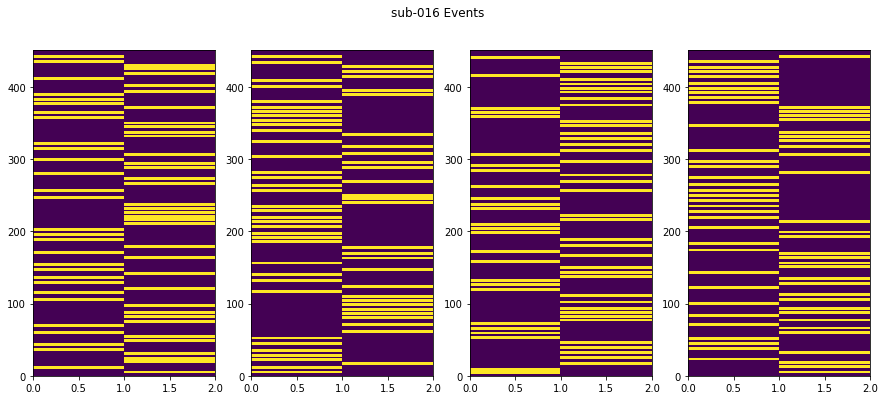

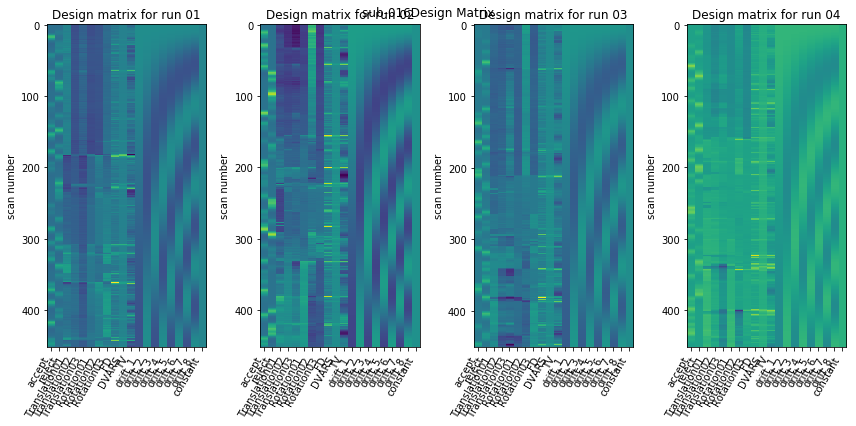

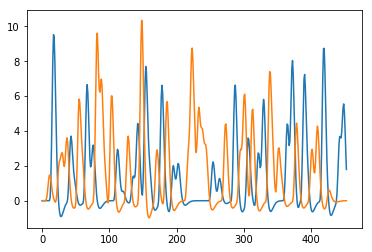

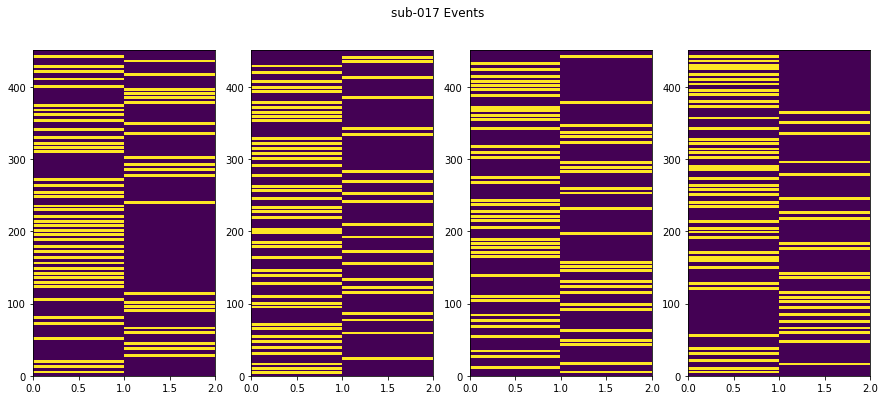

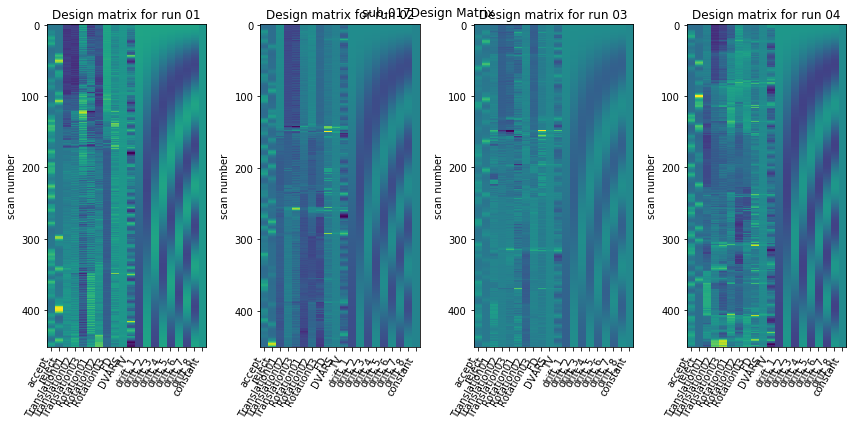

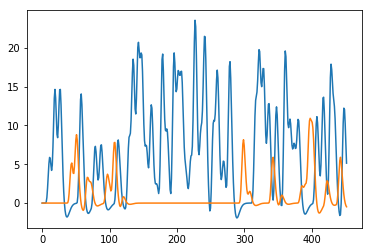

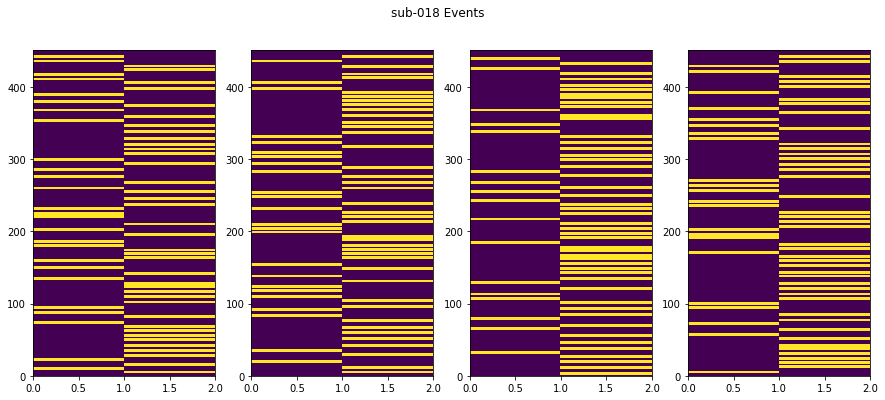

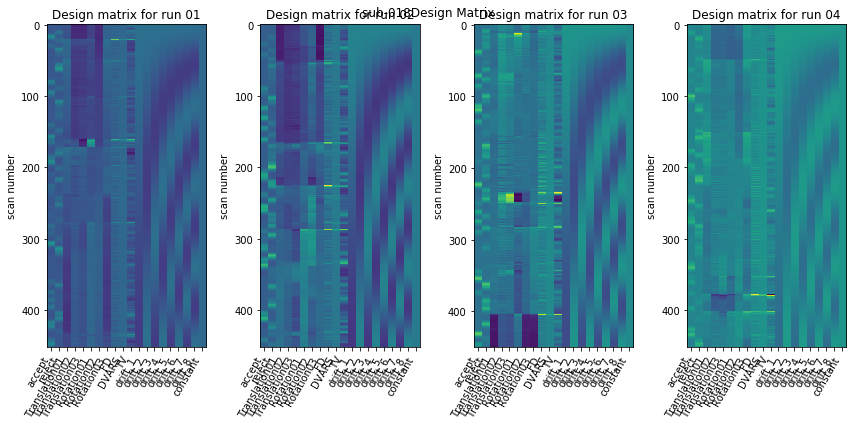

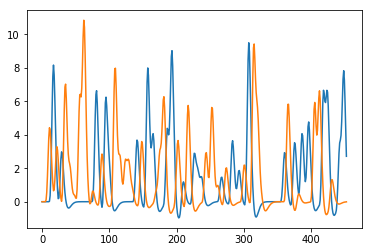

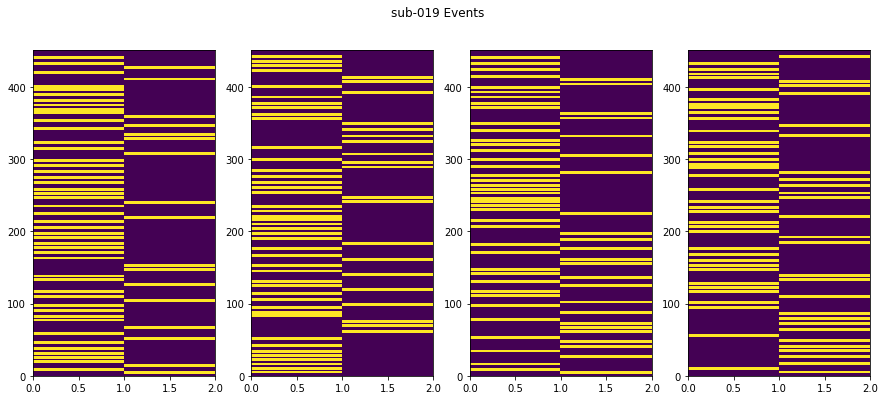

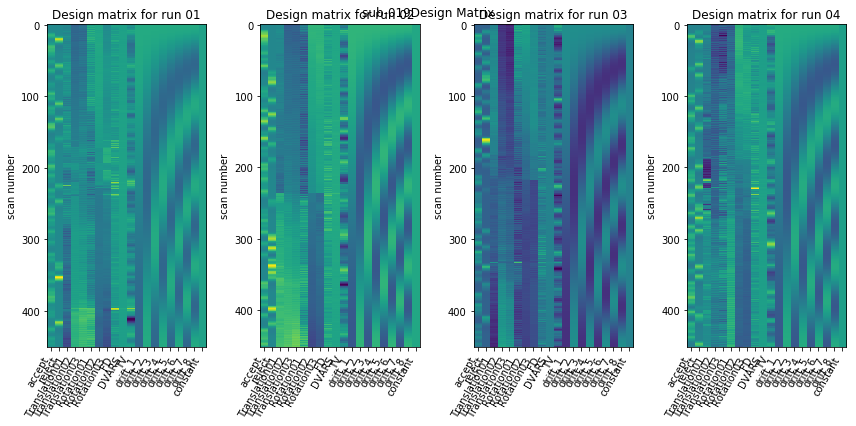

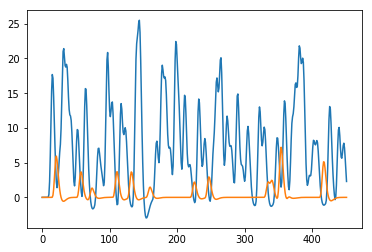

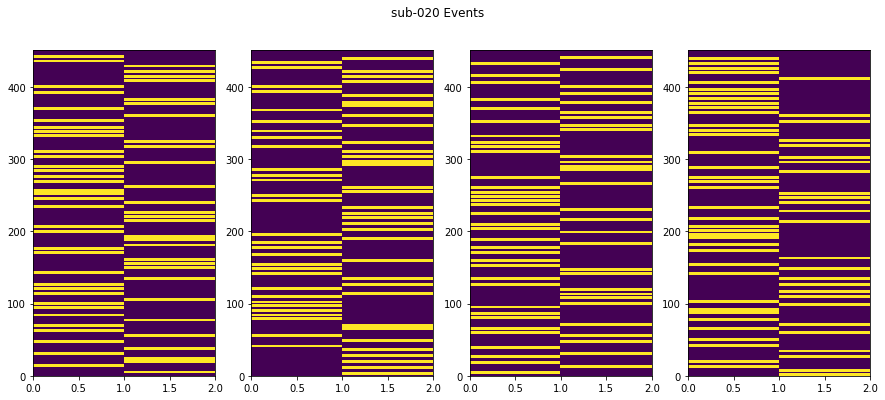

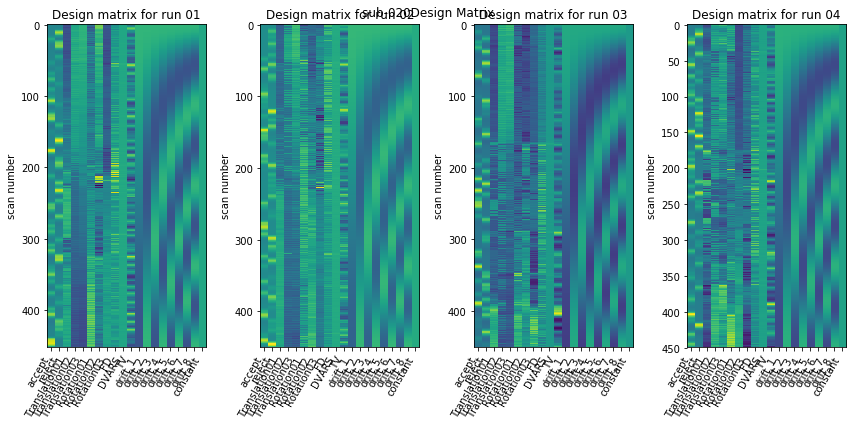

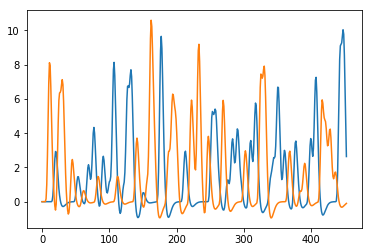

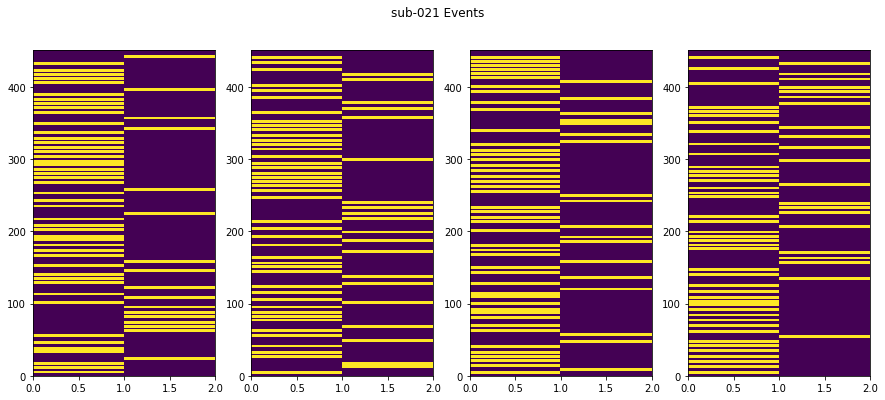

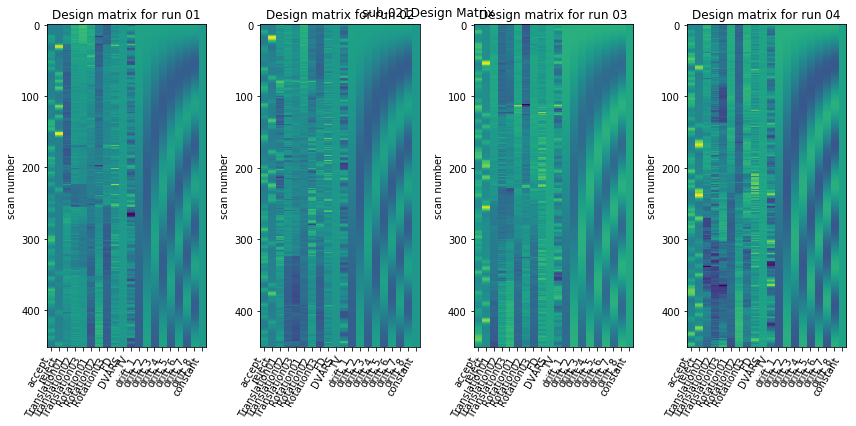

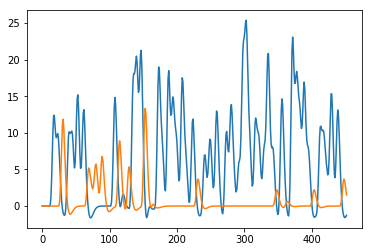

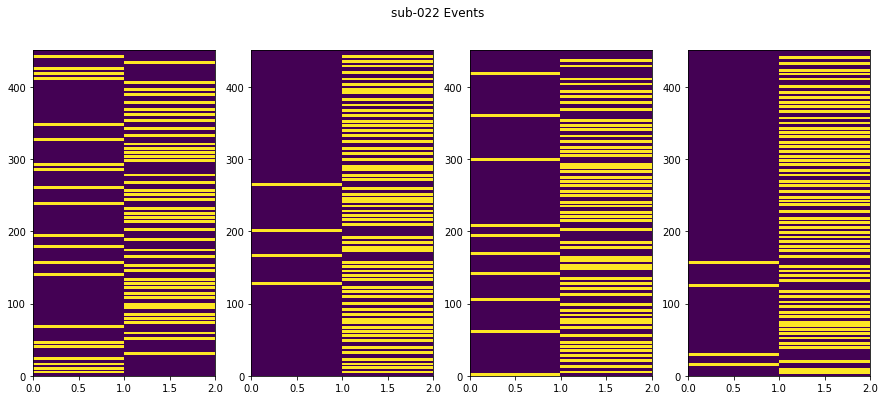

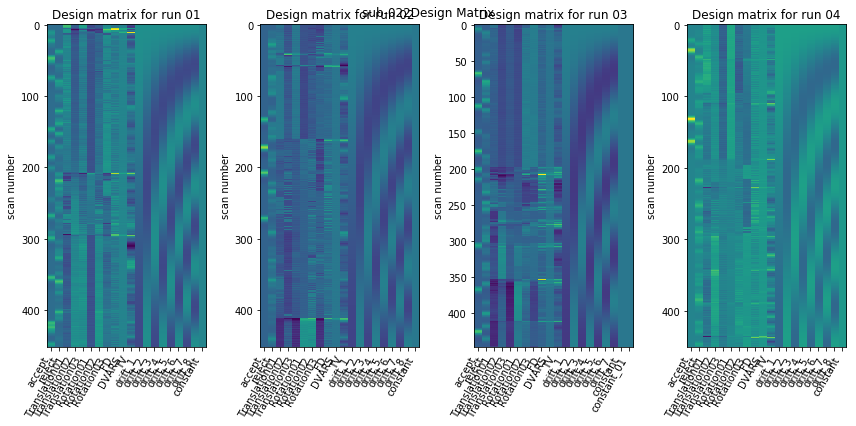

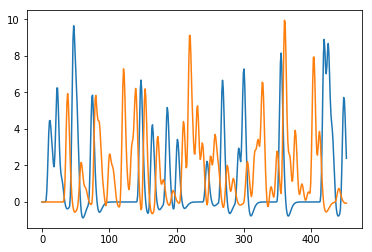

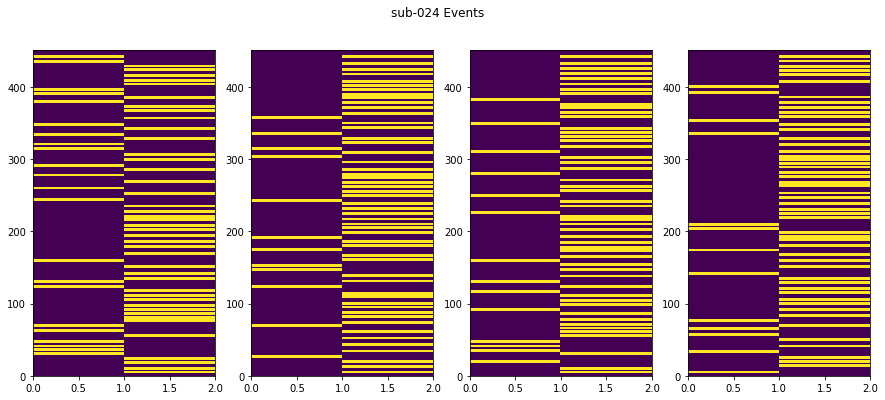

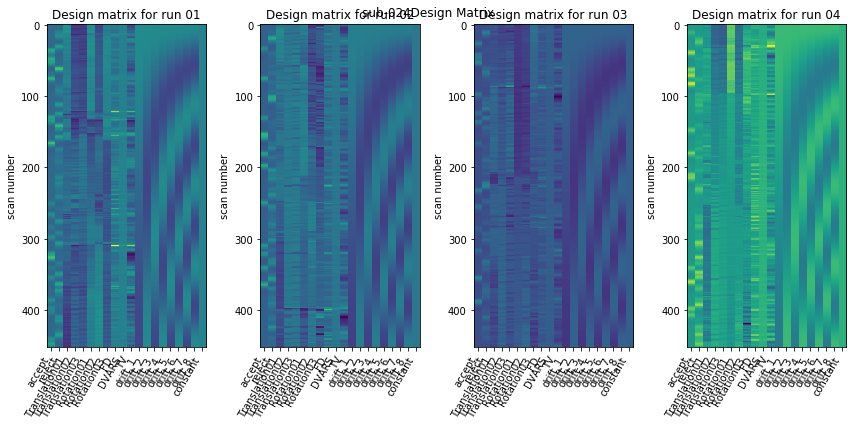

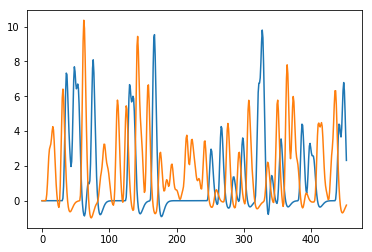

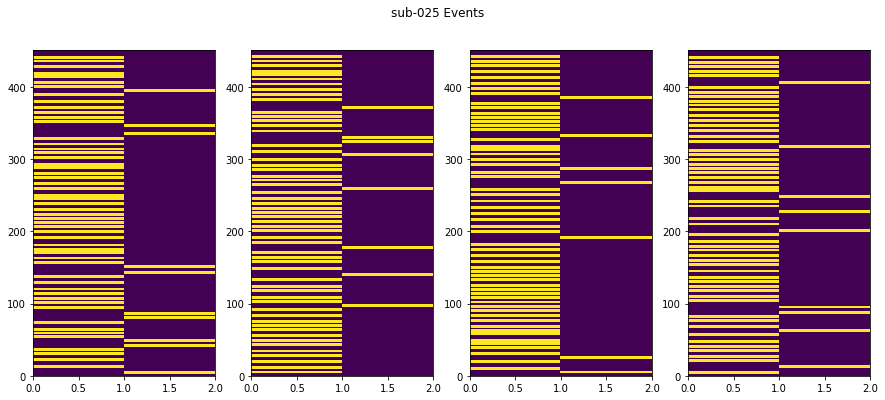

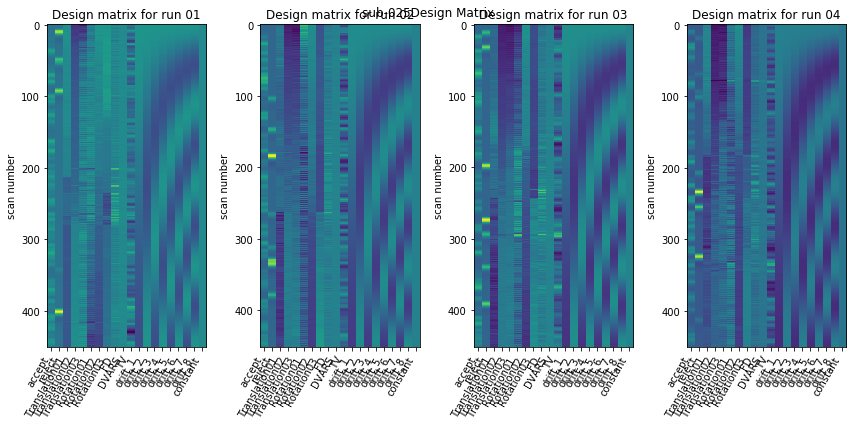

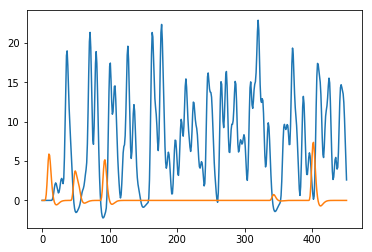

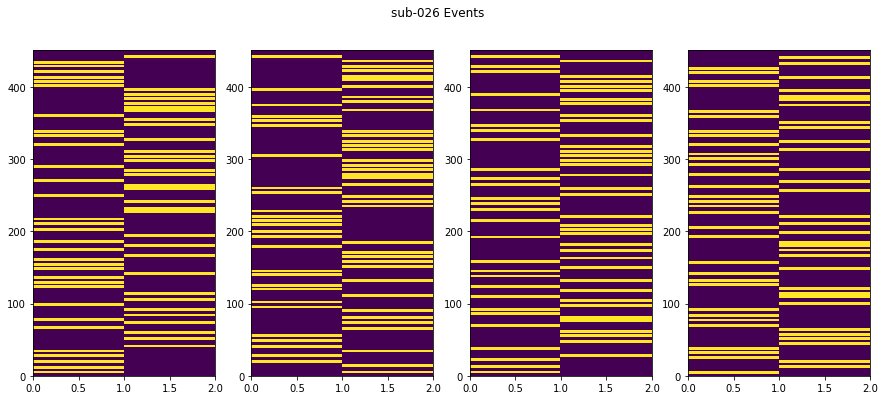

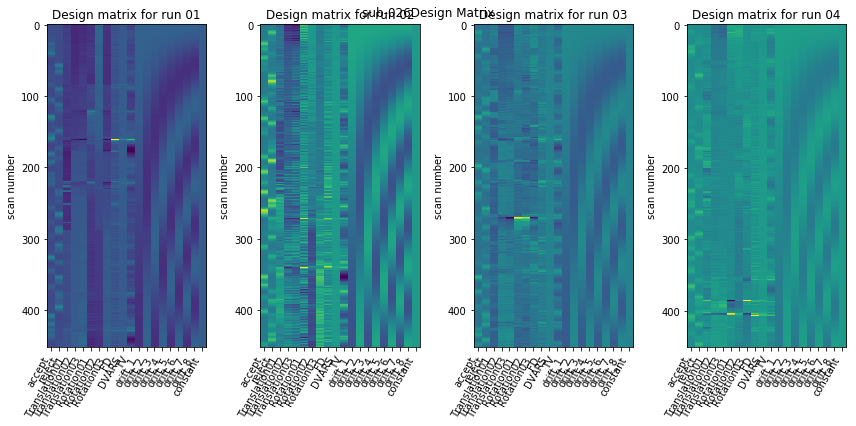

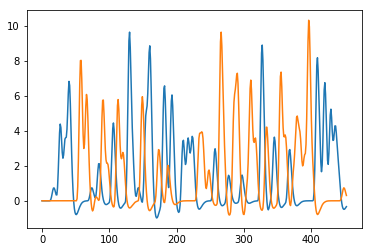

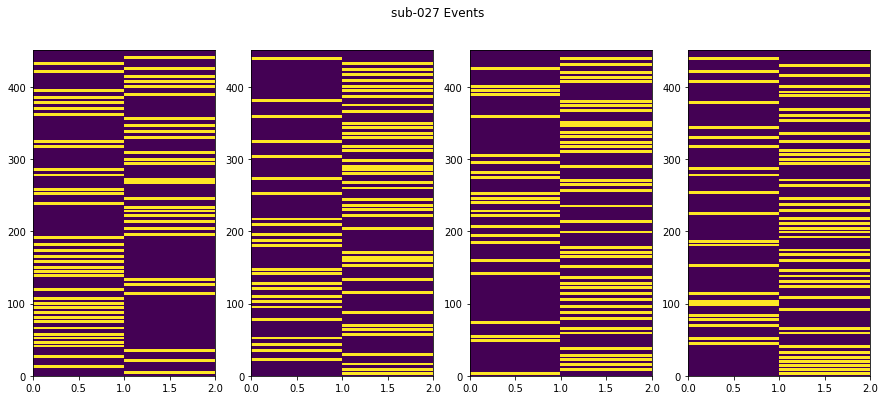

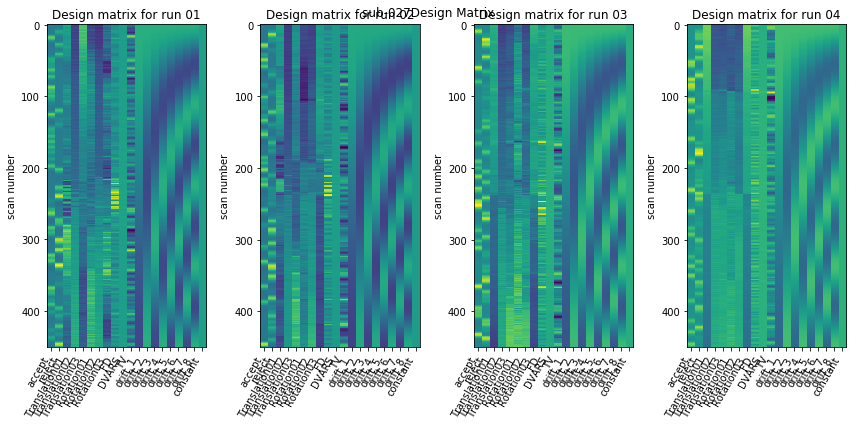

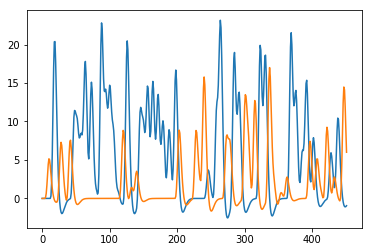

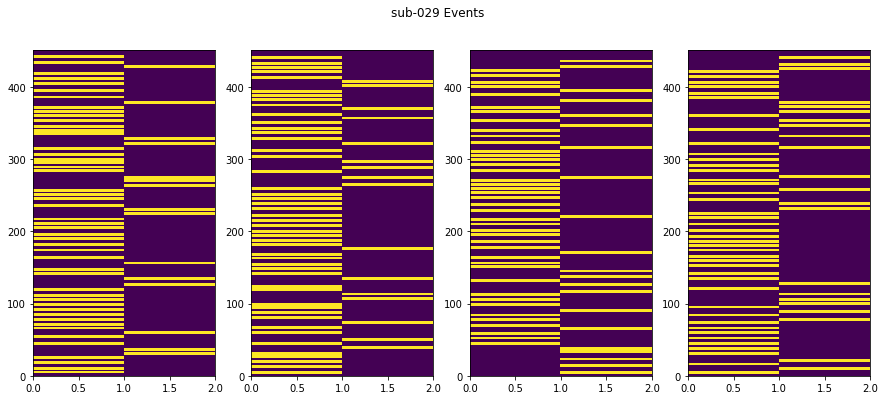

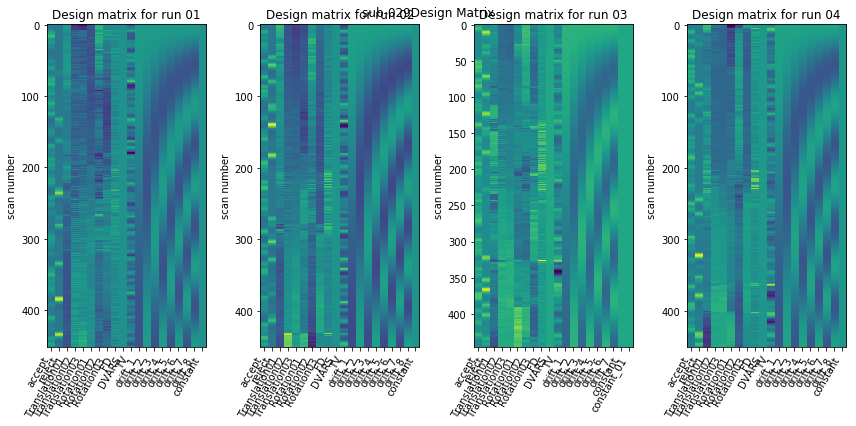

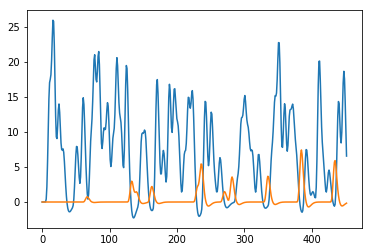

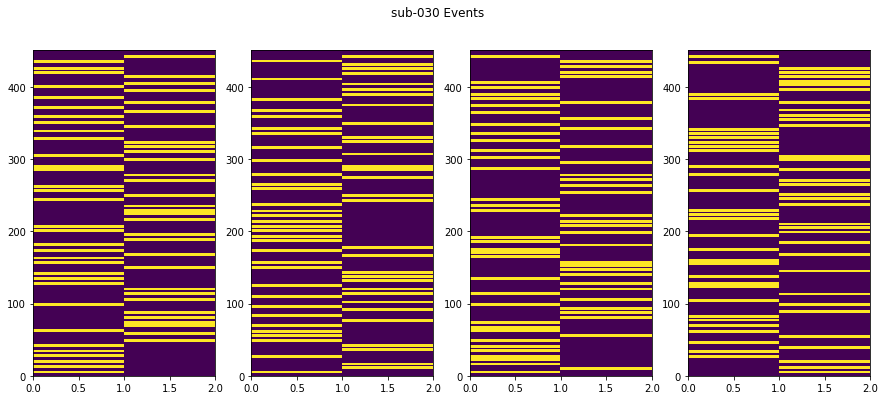

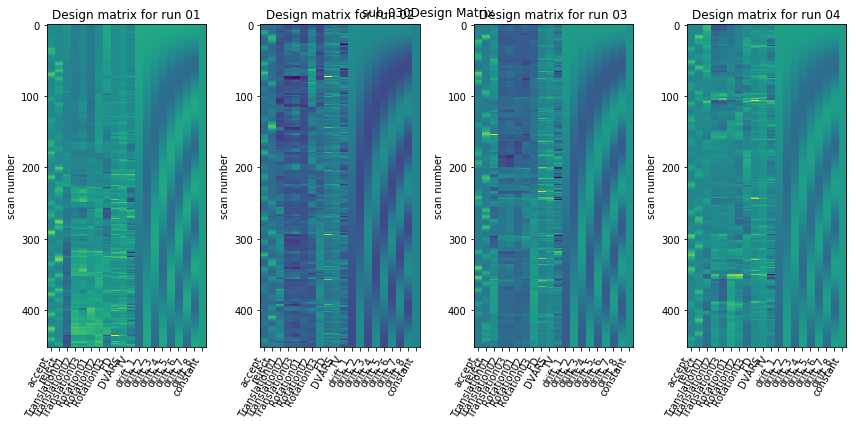

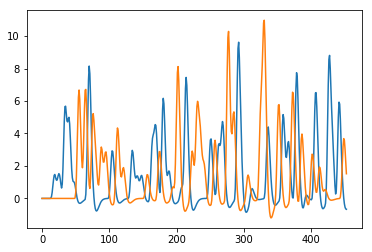

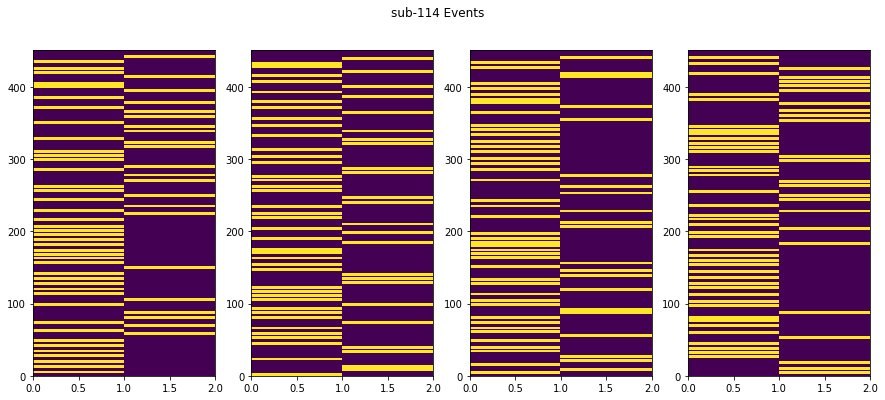

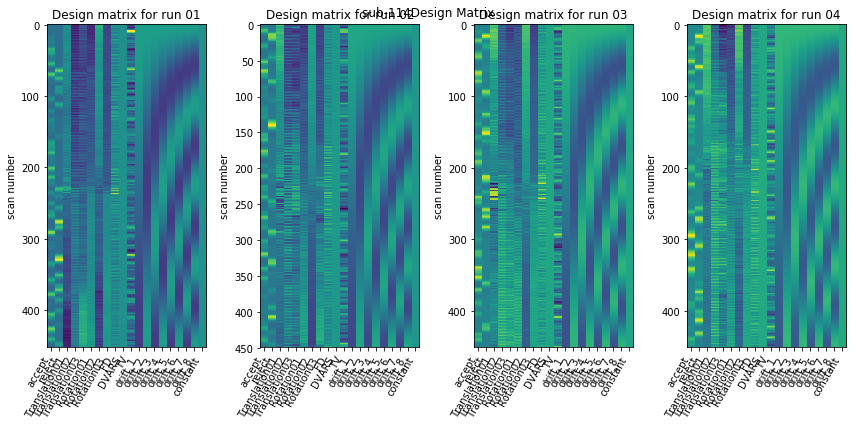

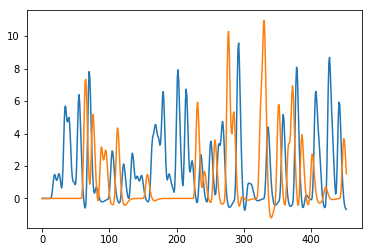

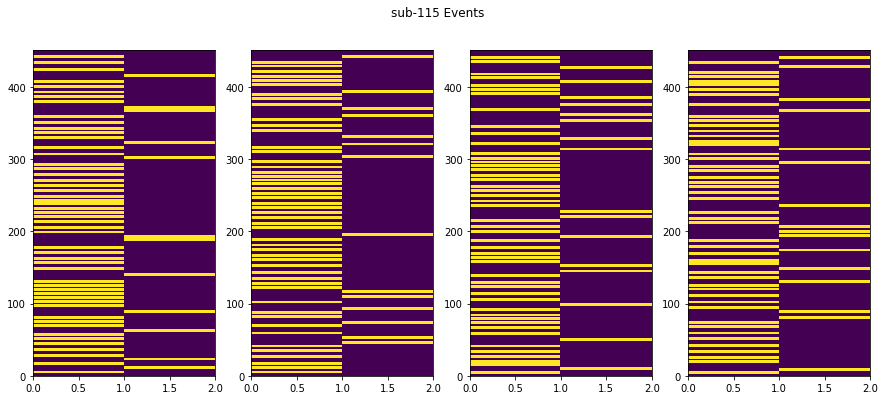

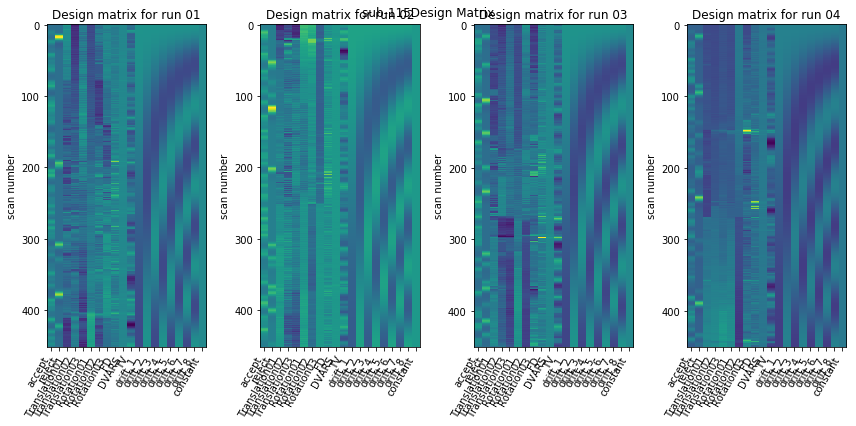

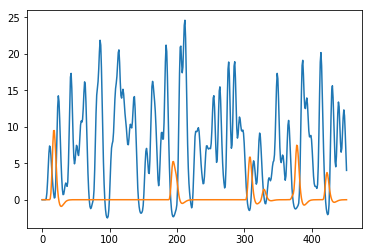

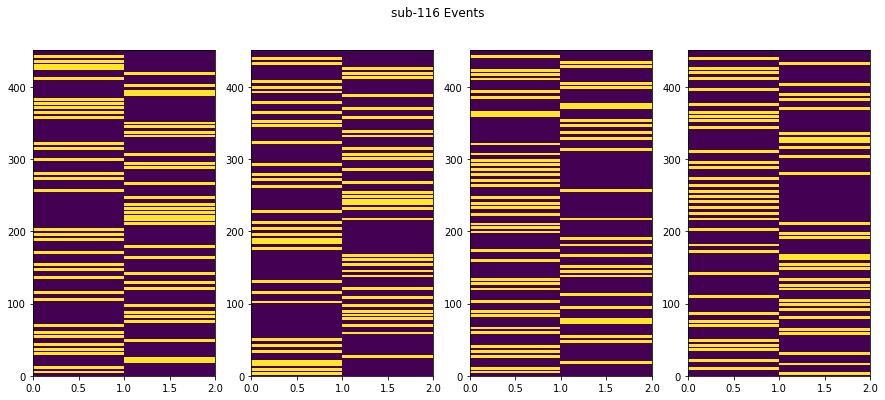

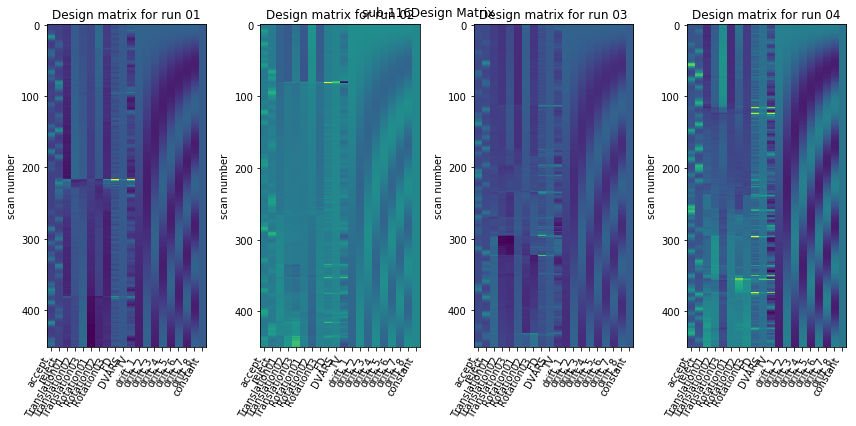

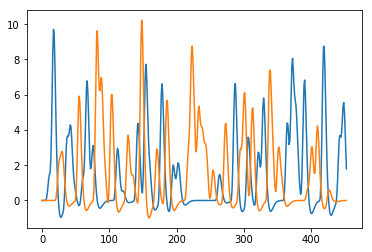

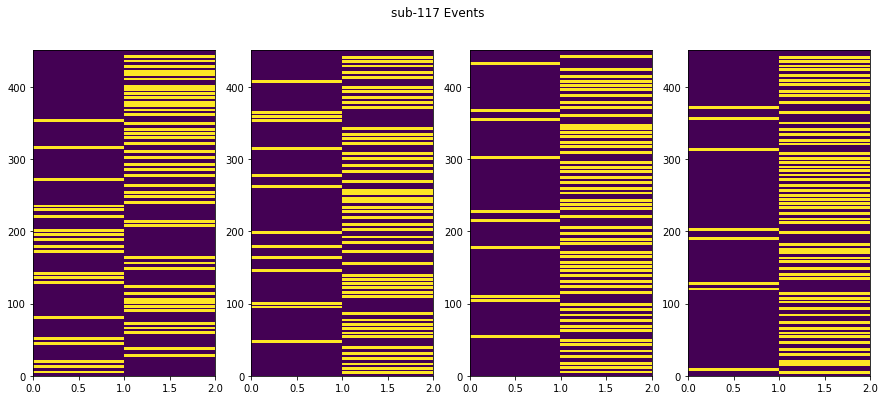

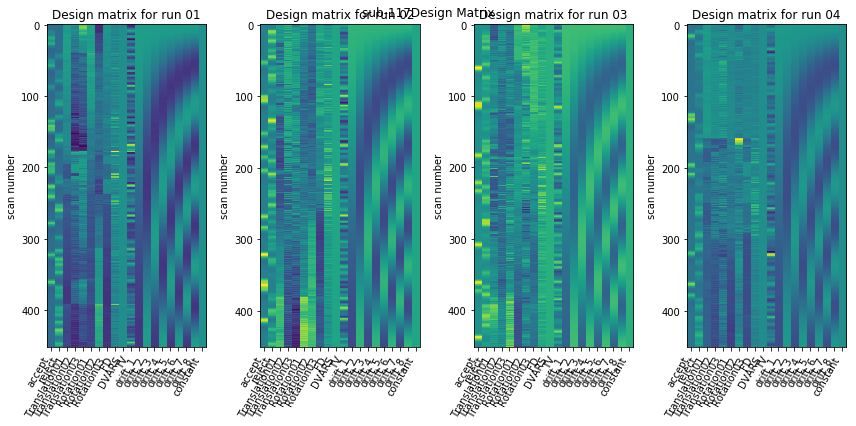

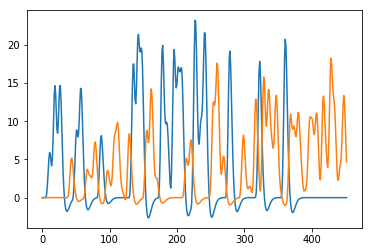

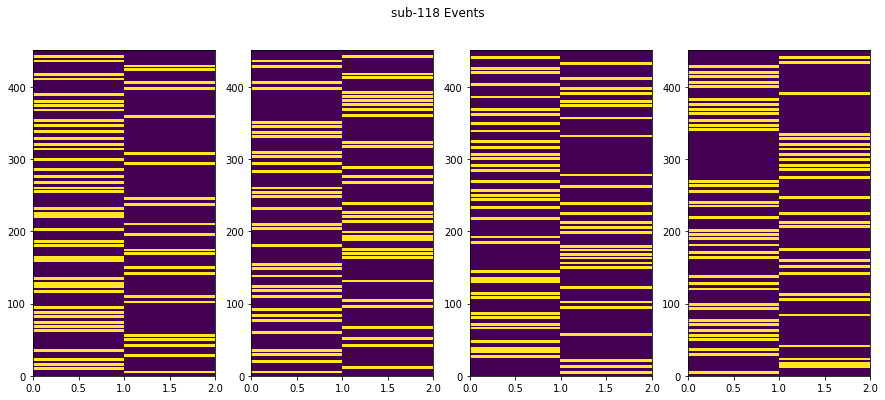

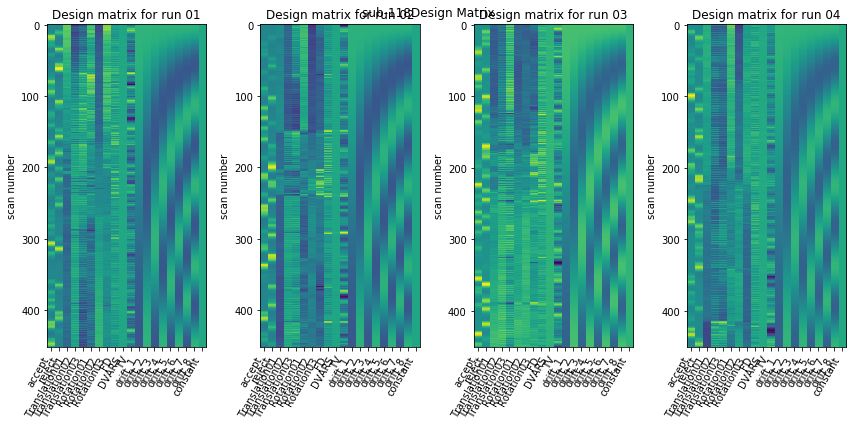

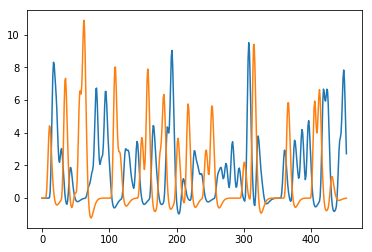

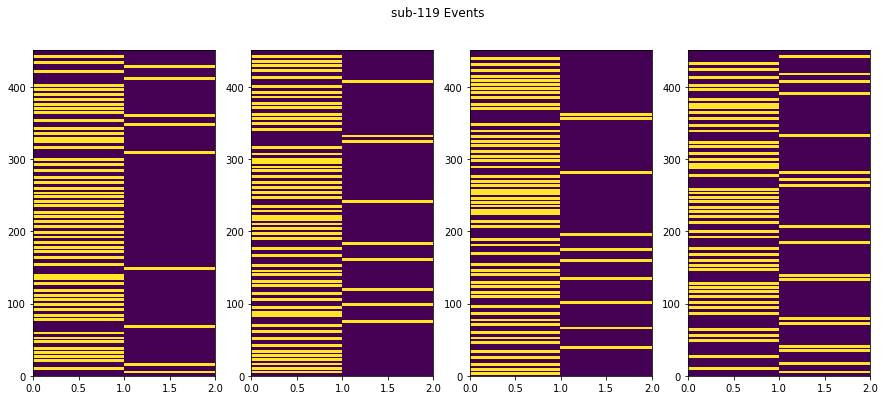

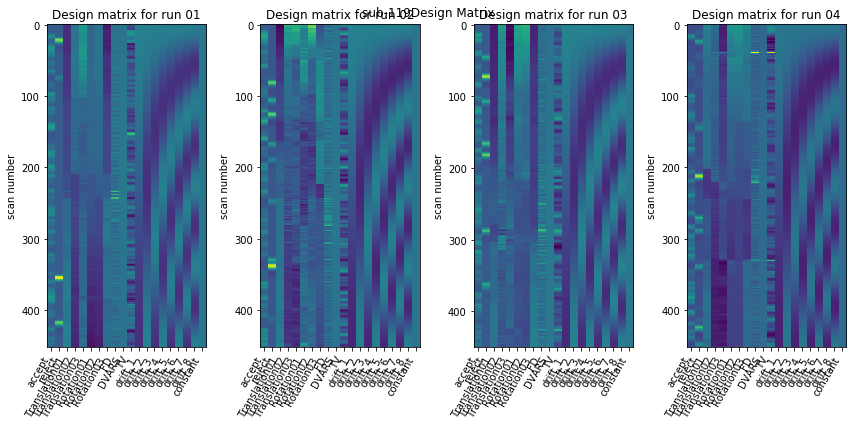

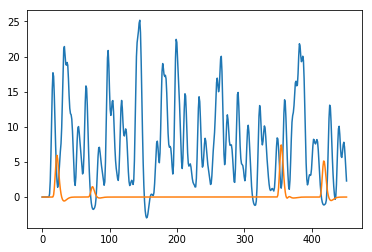

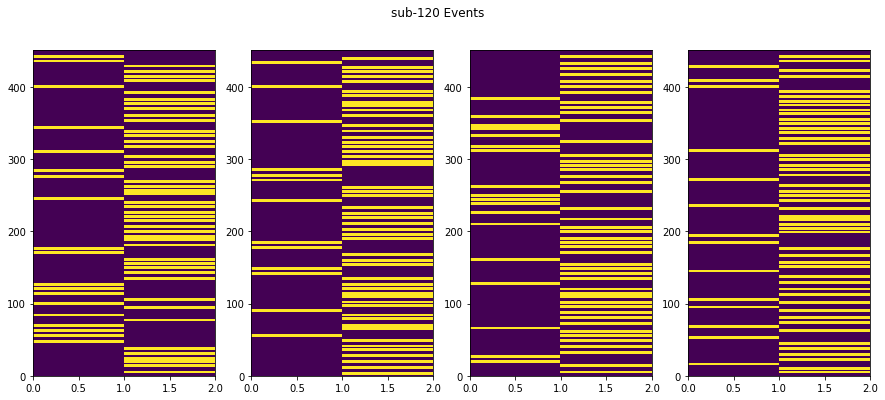

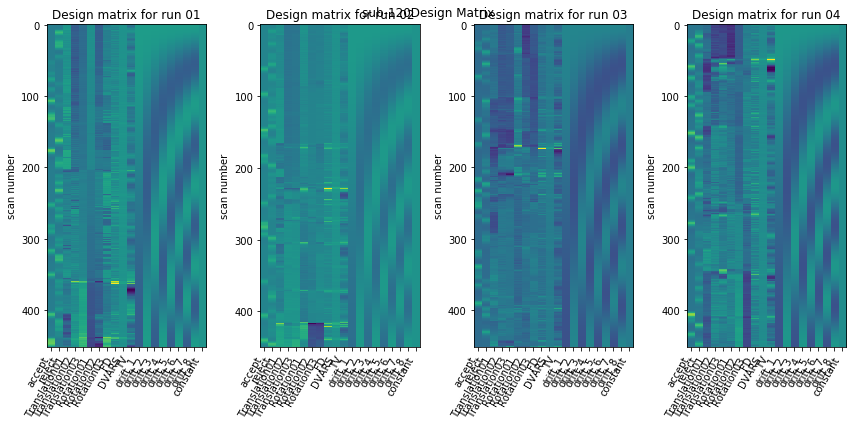

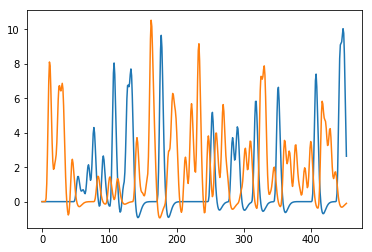

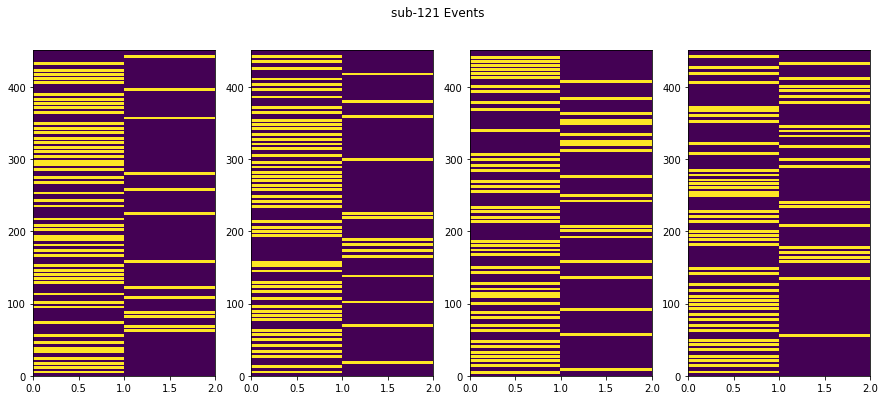

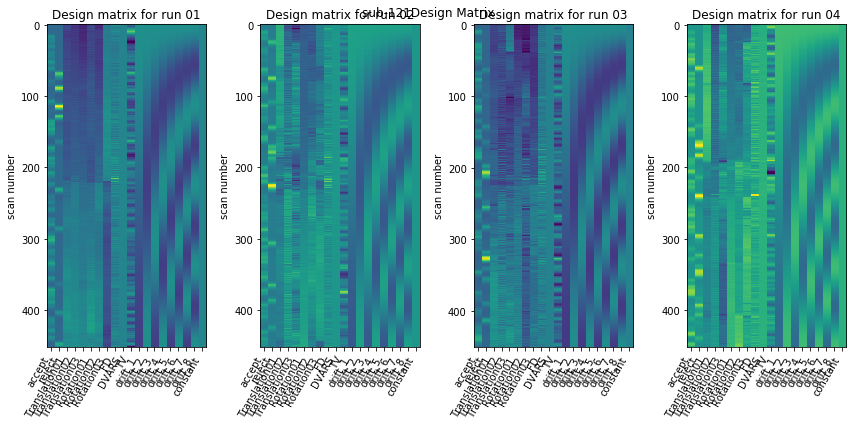

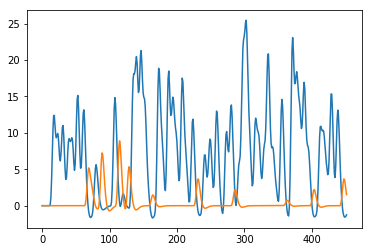

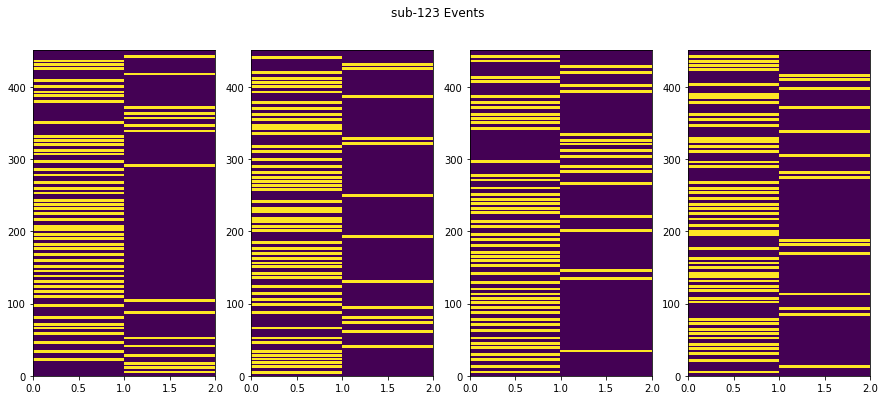

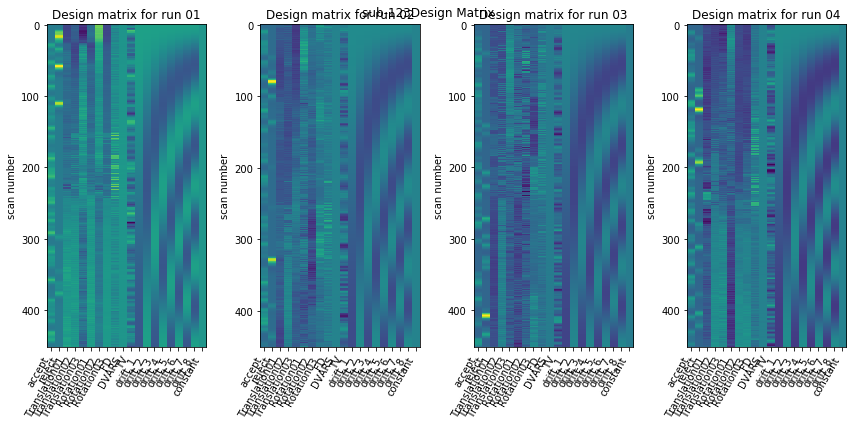

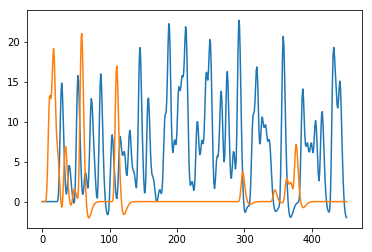

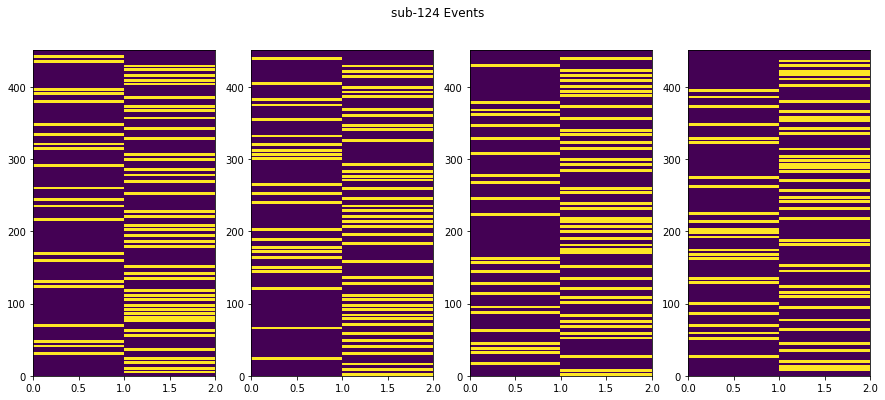

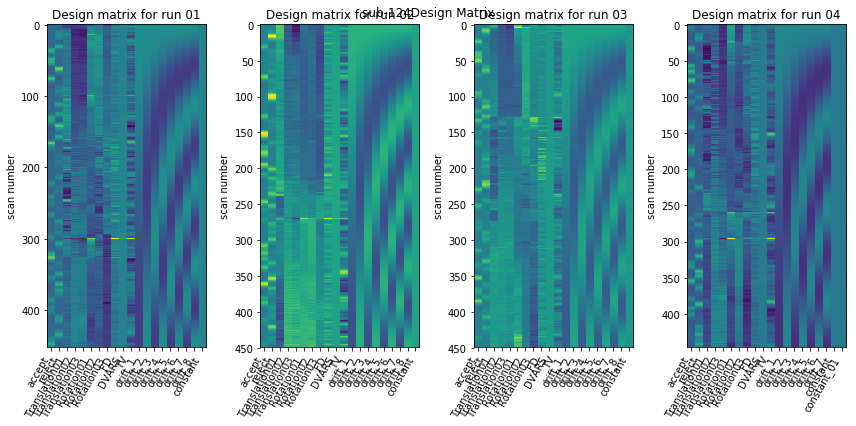

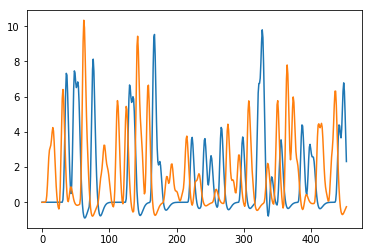

In [26]:
from nipype.interfaces.ants import ApplyTransforms

# 1st level analysis subject loop
ind = np.arange(0, len(ev_data) + 1, 4) # use this to pick func data belongs to each participant
for s, subj in enumerate(subject_ids):
    sub_dir = root + '/derivatives/nistats/1st_level/' + subj

    print(subj)
    print(sub_dir)
    if not os.path.exists(sub_dir):
        os.makedirs(sub_dir)
    
    sub_func = func_data[ind[s]:ind[s+1]]
    sub_conf = motion_conf_all[ind[s]:ind[s+1]]
    sub_evs =  ev_data[ind[s]:ind[s+1]]
    print('nr of sub evs, nr of sub func data, nr of sub confounds')
    print(len(sub_evs), len(sub_func) ,len(sub_conf))
    
    # Plot the events and save the figure
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))
    ax=ax.flatten()
    for run in range(runs_per_sub):
        events = sub_evs[run]
        onsets_accept = np.asarray(events.onset[events['trial_type'] == 'accept']).astype(int)
        onsets_reject = np.asarray(events.onset[events['trial_type'] == 'reject']).astype(int)
        
        # create a boolean array denoting the timing for different conditions
        temp = np.zeros((n_scans, nr_cond))
        for i in range(len(temp)):
            if i in onsets_accept / TR:
                for k in range(int(epoch_duration / TR)):
                    temp[i + k, 0] = 1
            if i in onsets_reject / TR:
                for k in range(int(epoch_duration / TR)):
                    temp[i + k, 1] = 1
        temp = temp.astype(bool) 
        ax[run].pcolormesh(temp)
        plt.suptitle(subj + ' Events')
        plt.savefig(sub_dir + '/' + subj + '_events.png')
    

    ############# FIT THE GLM #################
    fmri_glm_fit = fmri_glm.fit(sub_func, sub_evs, confounds=sub_conf)
    
    recompute_glm = False
    expected_size = 20
    for i in range(4):
        design_matrix = fmri_glm_fit.design_matrices_[i]
        dm_diff = expected_size - design_matrix.shape[-1]
        if dm_diff:
            for d in range(1, dm_diff + 1):
                design_matrix['constant_%02d' % d] = np.repeat(
                    1.0, len(design_matrix))
            recompute_glm = True
            
    if recompute_glm:
        fmri_glm_fit = fmri_glm.fit(sub_func, sub_evs, confounds=sub_conf,
                                    design_matrices=fmri_glm_fit.design_matrices_)
        recompute_glm = False

    # Plot the design matrix
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
    plot_design_matrix(fmri_glm_fit.design_matrices_[0], ax=ax1)
    ax1.set_title('Design matrix for run 01', fontsize=12)
    plot_design_matrix(fmri_glm_fit.design_matrices_[1], ax=ax2)
    ax2.set_title('Design matrix for run 02', fontsize=12)
    plot_design_matrix(fmri_glm_fit.design_matrices_[2], ax=ax3)
    ax3.set_title('Design matrix for run 03', fontsize=12)
    plot_design_matrix(fmri_glm_fit.design_matrices_[3], ax=ax4)
    ax4.set_title('Design matrix for run 04', fontsize=12)
    plt.suptitle(subj + 'Design Matrix')
    plt.savefig(sub_dir + '/' + subj + '_design_matrix.png')
    

    # Plot the contrasts
    design_matrix = fmri_glm_fit.design_matrices_[0]
    contrast_matrix = np.eye(design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(design_matrix.columns)])

    design_matrix = design_matrix.reset_index()
    fig, ax1 = plt.subplots()
    ax1.plot(design_matrix['accept'])
    ax1.plot(design_matrix['reject'])
    plt.savefig(sub_dir + '/' + subj + '_parametric_contrasts.png')

    # create and save zmaps
    conts = [contrasts['accept'], contrasts['reject'], contrasts['accept'] - contrasts['reject'] ]
    zmap_names = ['Accept', 'Reject', 'AcceptVsReject']
    bg_img = anat_data[s]
    for counter, contrast in enumerate(conts):
        z_map = fmri_glm_fit.compute_contrast(contrast, output_type='z_score')
        _, threshold = map_threshold(z_map, level=.001, height_control='fpr')
        print('Uncorrected p<0.001 threshold: %.3f' % threshold)
        plot_stat_map(z_map, threshold=threshold,
                      bg_img=bg_img,
                      display_mode='z', cut_coords=8, black_bg=True,
                      title = '{} (Z > {:.2})'.format(zmap_names[counter], threshold),
                      output_file=sub_dir + '/' + subj + '_zmap_axial_' + zmap_names[counter] + '.png')
        plot_stat_map(z_map, threshold=threshold,
                      bg_img=bg_img,
                      display_mode='y', cut_coords=8, black_bg=True,
                      title = '{} (Z > {:.2})'.format(zmap_names[counter], threshold),
                      output_file=sub_dir + '/' + subj + '_zmap_coronal_' + zmap_names[counter] + '.png')

        save_name = sub_dir + '/' + subj + '_zmap_' + zmap_names[counter] + '.nii.gz'
        z_map.to_filename(save_name)

        # Normalize contrast to template
        norm_template = root + '/derivatives/fmriflows/preproc_anat/template_brain_1.0_1.0_1.0.nii.gz'
        ants_transform = root + '/derivatives/fmriflows/preproc_anat/{0}/{0}_transformComposite.h5'.format(subj)
        con_norm = save_name.replace('.nii.gz', '_norm.nii.gz')
        
        ApplyTransforms(
            reference_image=norm_template,
            input_image_type=3,
            float=True,
            interpolation='NearestNeighbor',
            invert_transform_flags=[False],
            output_image=con_norm,
            input_image=save_name,
            transforms=[ants_transform]).run()
        
        _, threshold = map_threshold(z_map, level=.001, height_control='fpr')
        print('Uncorrected p<0.001 threshold: %.3f' % threshold)
        plot_stat_map(con_norm, threshold=threshold,
                      bg_img=norm_template,
                      display_mode='z', cut_coords=8, black_bg=True,
                      title = '{} (Z > {:.2})'.format(zmap_names[counter], threshold),
                      output_file=sub_dir + '/' + subj + '_zmap_axial_' + zmap_names[counter] + '_norm.png')
        plot_stat_map(con_norm, threshold=threshold,
                      bg_img=norm_template,
                      display_mode='y', cut_coords=8, black_bg=True,
                      title = '{} (Z > {:.2})'.format(zmap_names[counter], threshold),
                      output_file=sub_dir + '/' + subj + '_zmap_coronal_' + zmap_names[counter] + '_norm.png')